<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+0"><center> Demonstrations on a simulation </center></font> 

In this notebook, we demonstrate our method on simulations with biological realistic parameters to ensure that the simulated models accurately represent the behavior of biological systems. We do not add additional noise than we have accounted for in the model, which makes this a perfect scenario and upper bound of the performance.

We use a relatively complex and interesting trajectory structure: stay at the original steady state for a while, jump to the next state and then bifurcate.

# Load packages

In [1]:
cd ..

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import Chronocell
print(Chronocell.__version__)

from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS, GammaPoissonMixture
from Chronocell.utils import *
from Chronocell.plotting import *

2023.09.01


In [3]:
import numpy as np
import pickle
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import stats
from scipy.special import logsumexp, softmax
import copy
from sklearn.decomposition import PCA
import cmasher as cmr
import anndata as ad

In [4]:
plt.rcParams['font.size'] = '24'
plt.rcParams['lines.linewidth'] = 12
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '30'
legend_font = '24'
title_font = '36'

# Parameters and function

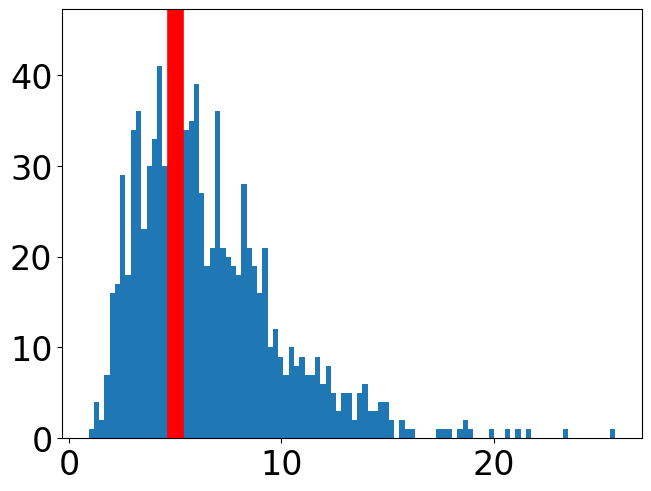

In [5]:
n=1000
logb_mu = 2
logb_sd = 0.5
beta = np.random.lognormal(logb_mu,logb_sd,size=n)

plt.hist(60*np.log(2)/beta,bins=100);
plt.axvline(x=5,color='r')

17.57793624262879

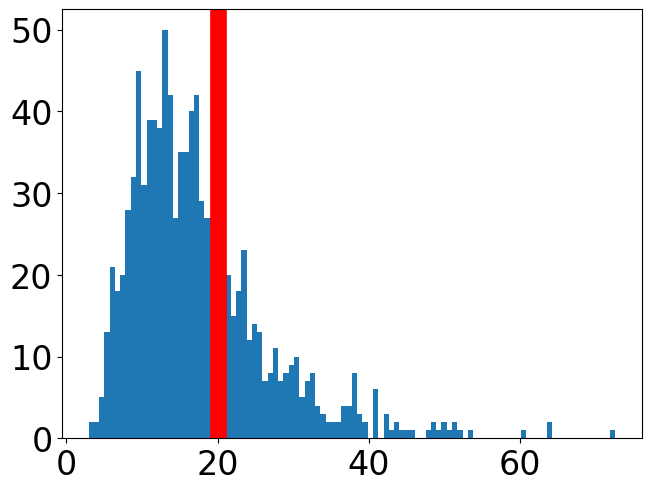

In [6]:
logb_mu=1
logb_sd=0.5
gamma = np.random.lognormal(logb_mu,logb_sd,size=n)
plt.hist(60*np.log(2)/gamma,bins=100);
plt.axvline(x=20,color='r')
(np.log(2)/gamma).mean()*60

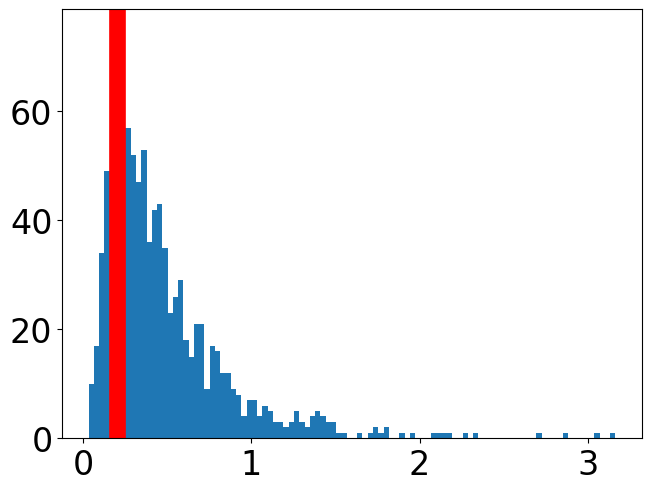

In [7]:
plt.hist(gamma/beta,bins=100);
plt.axvline(x=0.2,color='r')

0.47816501333117994 1.6188915035878249


0.24932019059516772

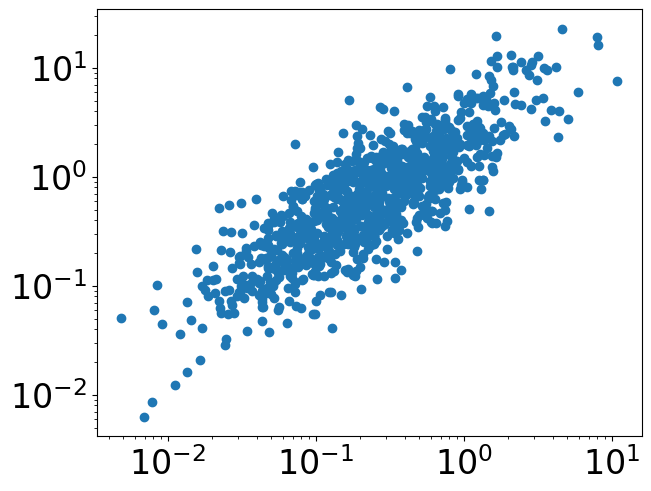

In [8]:
loga_mu = 2
loga_sd = 1
rd_mu = 0.25
rd_var = 0.25
alpha = np.random.lognormal(loga_mu, loga_sd,size=n)
a = (1-rd_mu)/rd_var - rd_mu
b = (1/rd_mu-1)*a
rd = np.random.beta(a=a, b=b, size=n)             
plt.loglog(rd*alpha/beta,rd*alpha/gamma,'.',zorder=0);
print(np.mean((rd*alpha/beta)[rd*alpha/beta>0.02]),np.mean((rd*alpha/gamma)[rd*alpha/beta>0.1]))
rd.var()/rd.mean()**2

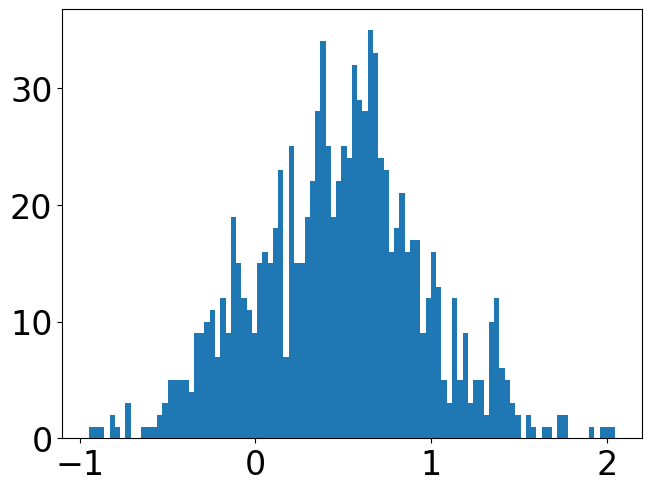

In [9]:
plt.hist(np.log10(alpha/gamma),bins=100);

In [10]:
from RADOM.models.two_species_ss import get_Y

def simulate_demo_data(topo, tau, n=1000, p=200, null_p=100, t_samples=None, loga_mu=2, loga_sd=1, logb_mu=2, logb_sd=0.5, rd_mu=0.25, rd_var=0.25, phi=0, random_seed=42, filepath=None, plot=True):    
    np.random.seed(random_seed)
    L=len(topo)
    K=len(tau)-1
    n_states=len(set(topo.flatten()))
    
    theta=np.zeros((p,n_states+2))
    theta[:,:n_states]=np.random.lognormal(loga_mu,loga_sd,size=(p,n_states))
    theta[:,-2:]=np.random.lognormal(logb_mu,logb_sd,size=(p,2))
    theta[:,:n_states]/=theta[:,-2,None]
    theta[:,-1]/=np.exp(1.5)
    theta[-null_p:,:n_states]=theta[-null_p:,0,None]
    
    true_t = []
    Y = np.zeros((n*L,p,2))
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
        t = np.sort(np.random.uniform(tau[0],tau[-1],size=n))
        Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
        true_t = np.append(true_t,t)

    if rd_var != 0:
        a = (1-rd_mu)/rd_var - rd_mu
        b = (1/rd_mu-1)*a
        read_depth = np.random.beta(a=a, b=b, size=n*L)             
    else:
        read_depth = np.ones(n*L) * rd_mu     
        
    Z = rd_mu*Y
    if phi > 0:
        Z *= np.random.gamma(shape=1/phi,scale=phi,size=(n*L,p,2))
    X = np.random.poisson(Z)
    
    if plot:
        fig, ax = plt.subplots(1,4,figsize=(24,4))
        ax[0].hist(theta[:,:-2].flatten(),bins=100)
        ax[0].set_title("α")
        ax[1].hist(theta[:,-2:].flatten(),bins=10)
        ax[1].set_title("β and γ")
        ax[2].hist(read_depth/read_depth.mean(),bins=100)
        ax[2].set_title("read depth")
        ax[3].hist(true_t,bins=100)
        ax[3].set_title("t")
    
    if filepath is not None:
        adata=ad.AnnData(np.sum(X,axis=-1),dtype=X.dtype)
        adata.layers["spliced"] = X[:,:,1]
        adata.layers["unspliced"] = X[:,:,0]
        adata.layers["ambiguous"]=np.zeros_like(X[:,:,0])
        adata.obs["time"]=true_t
        adata.obs["celltype"]=topo[(np.arange(n*L)//n),np.array(true_t*K/tau[-1],dtype=int)]
        adata.obs["read_depth"]=read_depth
        adata.varm["theta"]=theta
        adata.var["true_beta"]=theta[:,-2]
        adata.var["true_gamma"]=theta[:,-1]
        adata.write(filepath)
        
    return theta, true_t, rd_mu*Y, X, read_depth

# Generate data

1.14227

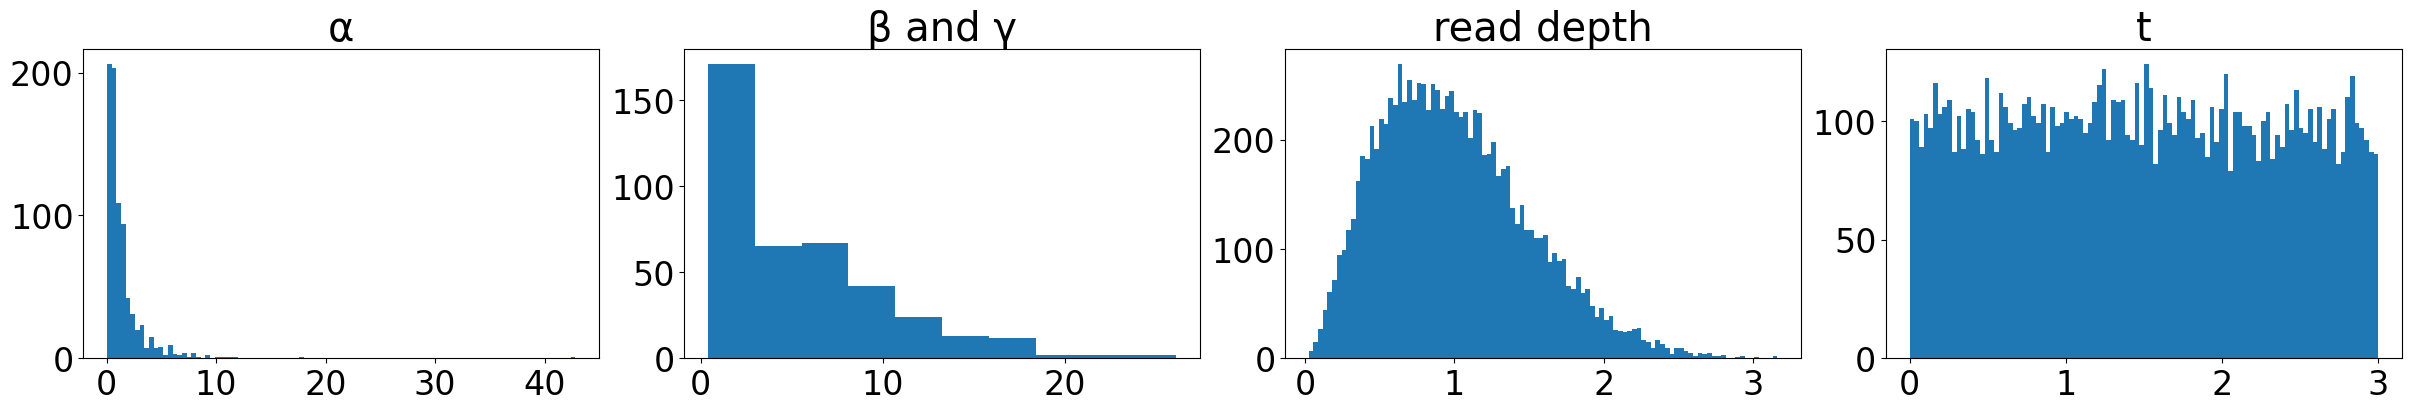

In [11]:
true_topo=np.array([[0,1,2],[0,1,3]])
true_tau = (0,2,3)
topo=np.array([[0,1,2,3],[0,1,2,4]])
tau=(0,1.,2.,3.)
L=len(topo)
n=5000
true_theta, true_t, Y, X, rd = simulate_demo_data(true_topo, true_tau, n=n, random_seed=42, filepath="data/sim_demo_.h5ad")
X.mean()

In [12]:
adata = ad.read("data/sim_demo.h5ad")
true_theta = np.array(adata.varm["theta"])
rd = np.array(adata.obs["read_depth"])
true_t = np.array(adata.obs["time"])
N, p = adata.X.shape
X = np.zeros((N,p,2))
X[:,:,1] = adata.layers["spliced"]
X[:,:,0] = adata.layers["unspliced"]
X.mean()

1.14181425

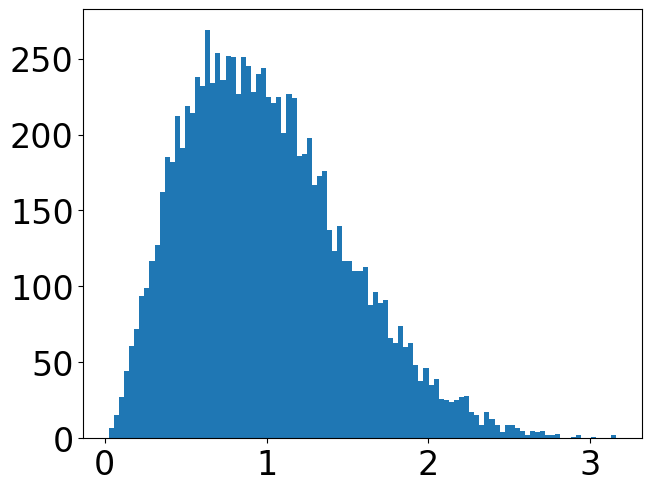

In [13]:
r = rd/rd.mean()
plt.hist(r,bins=100);

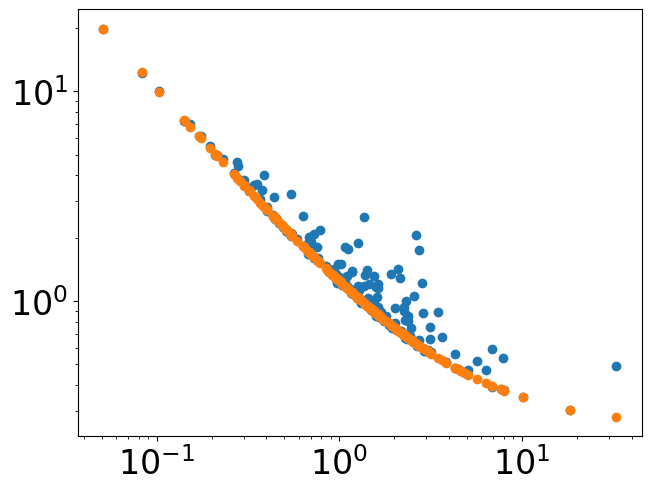

In [14]:
plt.loglog(X[:,:,1].mean(0),X[:,:,1].var(0)/X[:,:,1].mean(0)**2,'.')
plt.loglog(X[:,:,1].mean(0),1/X[:,:,1].mean(0)+0.25,'.')

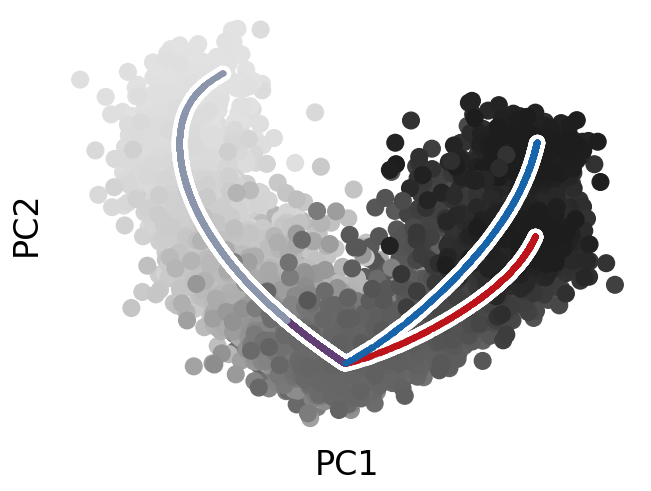

In [15]:
n = len(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.log1p(X.reshape(len(X),-1)/r[:,None]))
Y_pca = pca.transform(np.log1p(Y.reshape(len(Y),-1)))

light_purple = cmr.get_sub_cmap('Purples', 0., 1)(0.25)
purple = '#613f75'
blue = cmr.get_sub_cmap('Blues', 0., 1)(0.8)
red = cmr.get_sub_cmap('Reds', 0., 1)(0.8)

cmap_t = cmr.get_sub_cmap('Greys', 0.2, 0.9)
fig, ax = plt.subplots(1,1)
ax.scatter(X_pca[:,0],X_pca[:,1],c=true_t,cmap=cmap_t);

ax.scatter(Y_pca[(true_t > 1)&(true_t <= 2),0],Y_pca[(true_t > 1)&(true_t <= 2),1],s=100,color='w');
ax.scatter(Y_pca[(true_t>2) & (np.arange(n)>=n//L),0],Y_pca[(true_t>2) & (np.arange(n)>=n//L),1],s=100,color='w');
ax.scatter(Y_pca[(true_t>2) & (np.arange(n)<n//L),0],Y_pca[(true_t>2) & (np.arange(n)<n//L),1],s=100,color='w');
ax.scatter(Y_pca[(true_t<1) ,0],Y_pca[(true_t<1) ,1],s=100,color='w');

ax.scatter(Y_pca[(true_t > 1)&(true_t <= 2),0],Y_pca[(true_t > 1)&(true_t <= 2),1],s=10,color=purple);
ax.scatter(Y_pca[(true_t>2) & (np.arange(n)>=n//L),0],Y_pca[(true_t>2) & (np.arange(n)>=n//L),1],s=10,color=red);
ax.scatter(Y_pca[(true_t>2) & (np.arange(n)<n//L),0],Y_pca[(true_t>2) & (np.arange(n)<n//L),1],s=10,color=blue);
ax.scatter(Y_pca[true_t <= 1,0],Y_pca[(true_t <= 1),1],s=10,color='#8b96ad');
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

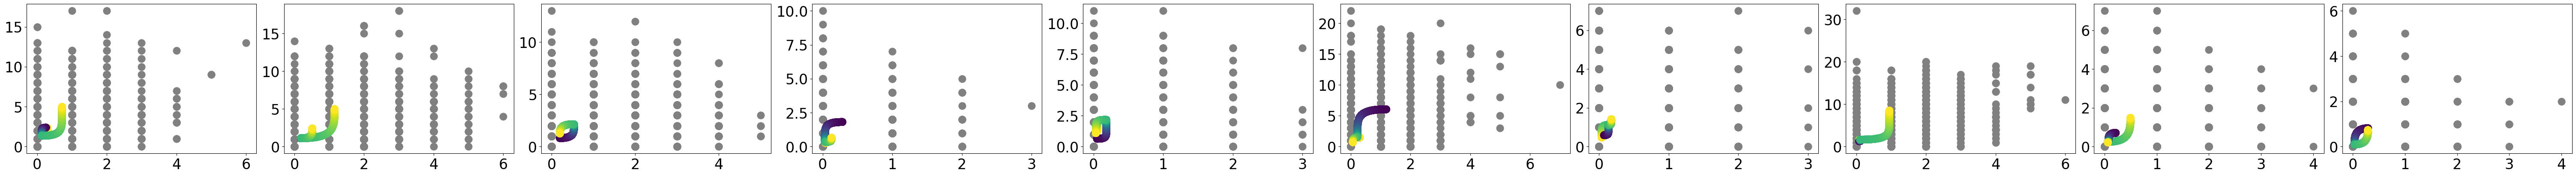

In [16]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c='gray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c=true_t);
# time increases from blue to red

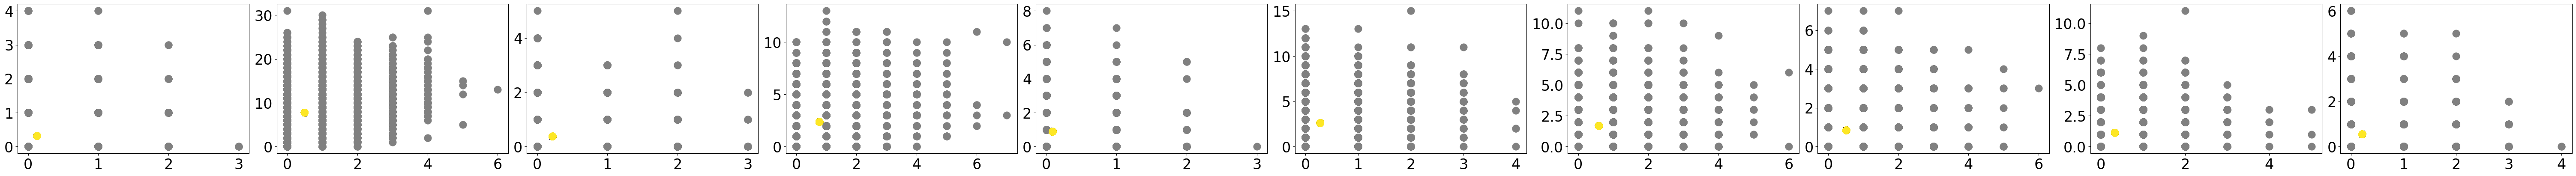

In [17]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(-p,0):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c='gray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c=true_t);
# time increases from blue to red

In [18]:
AICs = {}

In [19]:
with open('results/simulations_demo/simulation_demo_ri.pickle', 'rb') as f:
    data = pickle.load(f)
trajs = data['ri']
traj_ws = data['ws']

# Fine cluster

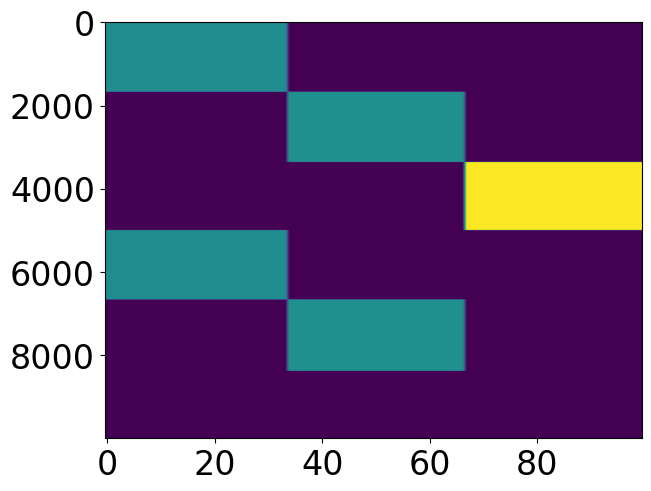

In [20]:
m=100
N=len(X)
Q0 = np.zeros((len(X),2,m))

idx = (true_t <= 1)
Q0[idx,:,:m//3+1] += 1

idx = (true_t > 1) & (true_t <= 2)
Q0[idx,:,int(m/3)+1:int(2*m/3)+1] += 1

idx = (true_t>2) & (np.arange(N)<N//L)
Q0[idx,0,int(2*m/3)+1:] += 1

idx = (true_t>2) & (np.arange(N)>=N//L)
Q0[idx,1,int(2*m/3)+1:] += 1

Q0=Q0/Q0.sum(axis=(1,2),keepdims=True)

plt.imshow(Q0[:,0],aspect='auto');

In [21]:
traj = Trajectory(topo,tau, model="two_species_ss", verbose=1)
traj = traj.fit(X,warm_start=True,Q=Q0,fit_tau=True,norm_Q=True,params={"r":rd/rd.mean()},epoch=100,parallel=True,n_threads=10)
traj.elbos[-1]

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


100%|██████████| 100/100 [07:02<00:00,  4.23s/it]


-391.10651268892184

In [22]:
traj_ws = copy.deepcopy(traj)

<AxesSubplot:>

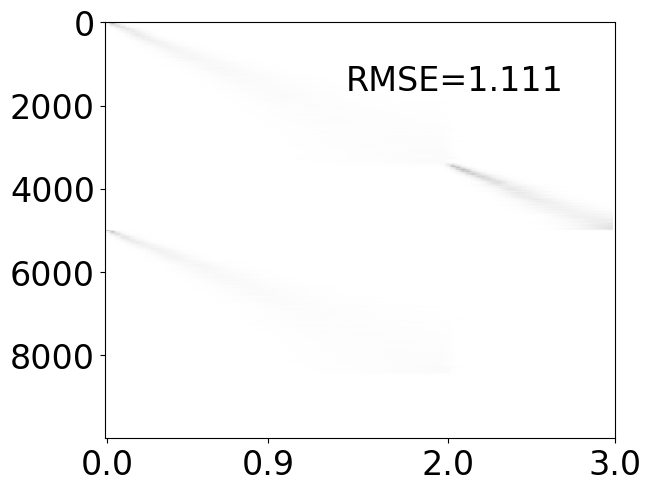

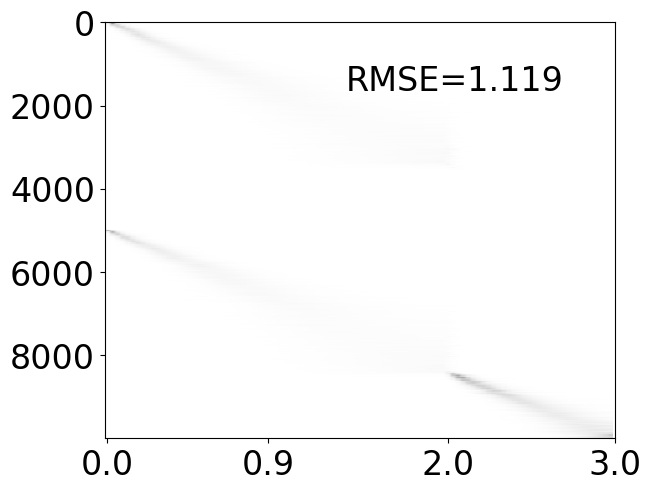

In [23]:
plot_t(traj,l=0,t=true_t);
plot_t(traj,l=1,t=true_t)

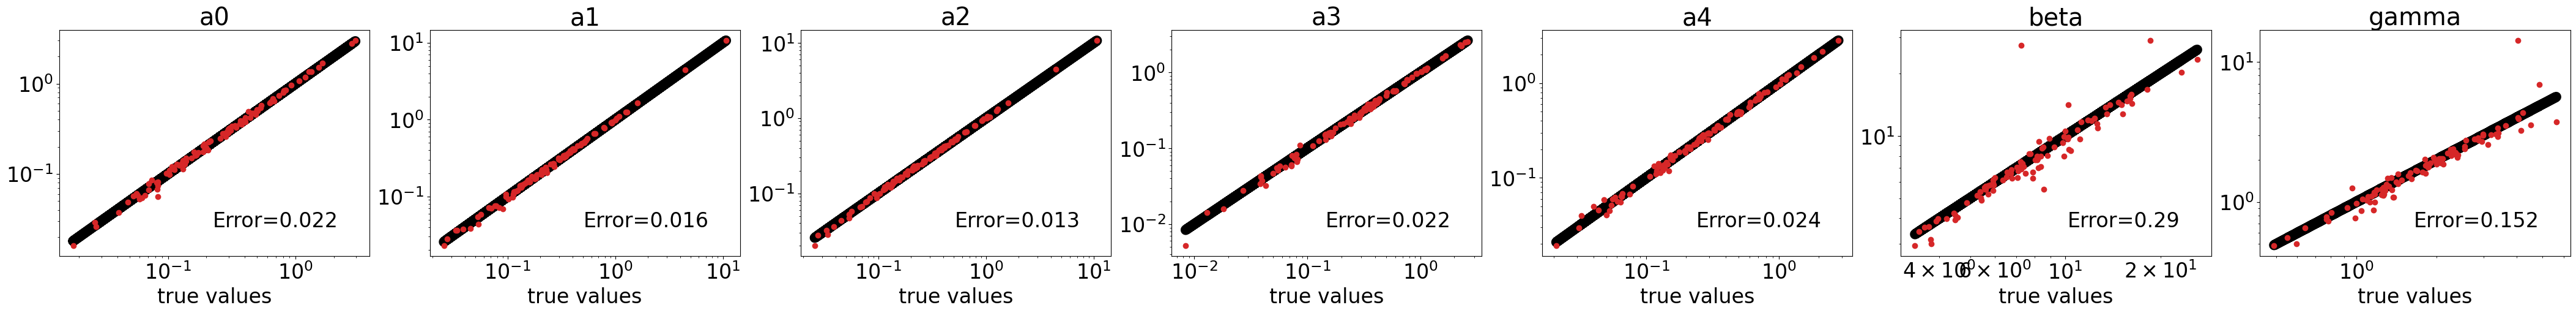

In [25]:
ax = plot_theta(true_theta[:100,[0,1,1,2,3,-2,-1]], traj.theta[:100], dot_color='tab:red')

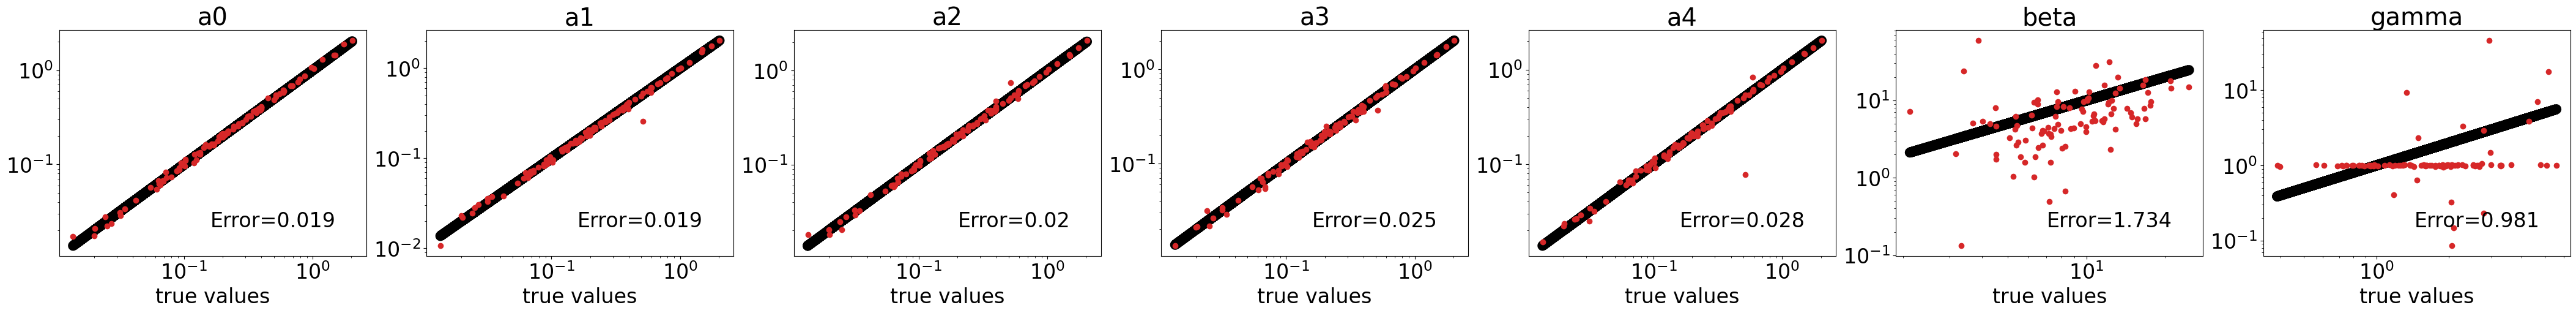

In [26]:
ax = plot_theta(true_theta[100:,[0,1,1,2,3,-2,-1]], traj.theta[100:], dot_color='gray')

In [27]:
traj_ws.compute_lower_bound(X), traj_ws.compute_AIC(X)

(-391.10651268892184, -391.2465126889219)

In [28]:
traj_ws.k

1400

# Random initialization

In [26]:
from multiprocessing import Pool

Input_args = []

def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,fit_tau=True,norm_Q=True,params={'r':rd/rd.mean()},perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs_ri = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [29]:
data = {'ri':trajs,'ws':traj_ws}

In [30]:
with open('results/simulations_demo/simulation_demo_ri.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

-391.1057102747658


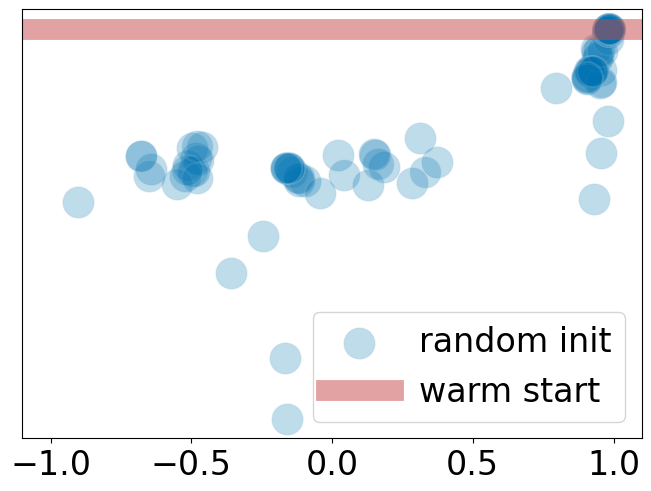

In [263]:
corrs = []
elbos = []
right_t = true_t
for traj in trajs:
    t_hat = traj.Q.sum(1) @ traj.t
    corrs.append(stats.pearsonr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )


fig, ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(corrs,elbos,s=2000,marker='.',edgecolors='#98c1d9',color='#0074b3',alpha=0.25,label='random init')
ax.axhline(y=traj_ws.elbos[-1],linewidth=15,color='#c74546',alpha=0.5,label='warm start')

ax.set_xlim((-1.1,1.1))
ax.axes.get_yaxis().set_visible(False)
#ax.set_ylabel('ELBO',fontsize=24);
plt.legend(loc="lower right",fontsize=legend_font);

traj = trajs[np.argmax(elbos)]
print(np.max(elbos))

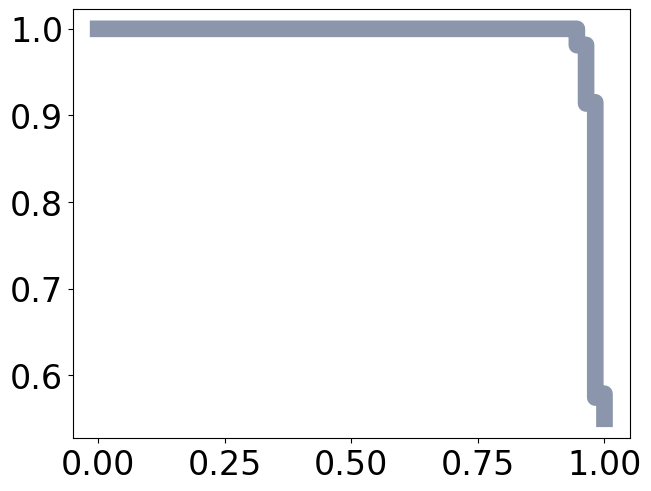

In [96]:
from sklearn.metrics import average_precision_score, precision_recall_curve

corrs = np.array(corrs)
elbos = np.array(elbos)
is_correct_direction = np.array(corrs>0.8,dtype=bool)
corrs_ratio = np.mean(is_correct_direction)

precision, recall, thresholds = precision_recall_curve(y_true=is_correct_direction,probas_pred=elbos)
score =  average_precision_score(y_true=is_correct_direction, y_score=elbos)
plt.plot(recall, precision,'.-',color='#8b96ad',label=np.around(score,3))

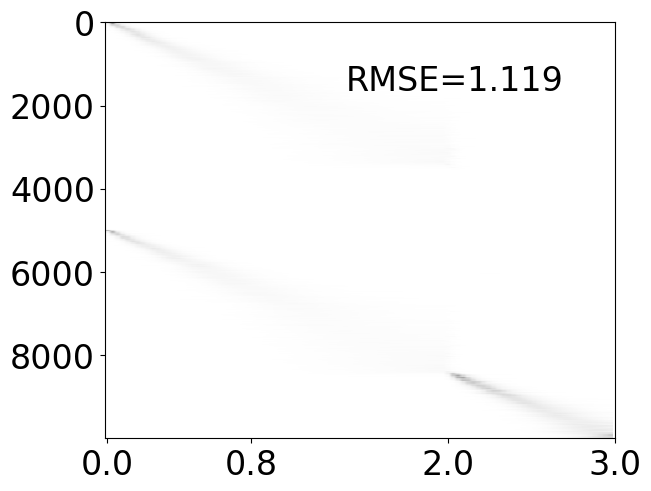

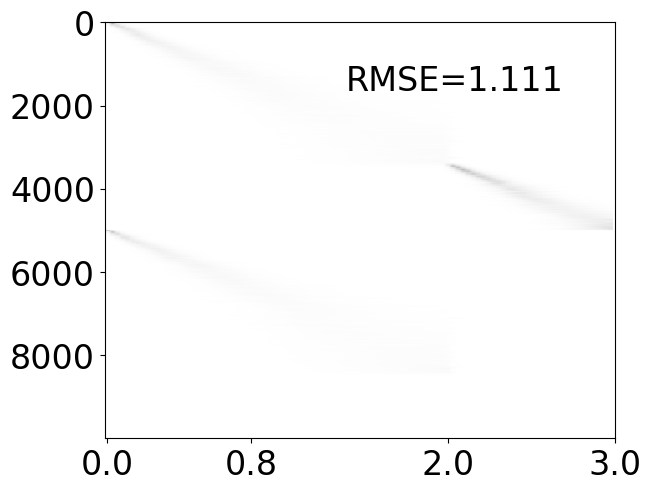

In [97]:
plot_t(traj,l=0,t=true_t);
plot_t(traj,l=1,t=true_t);

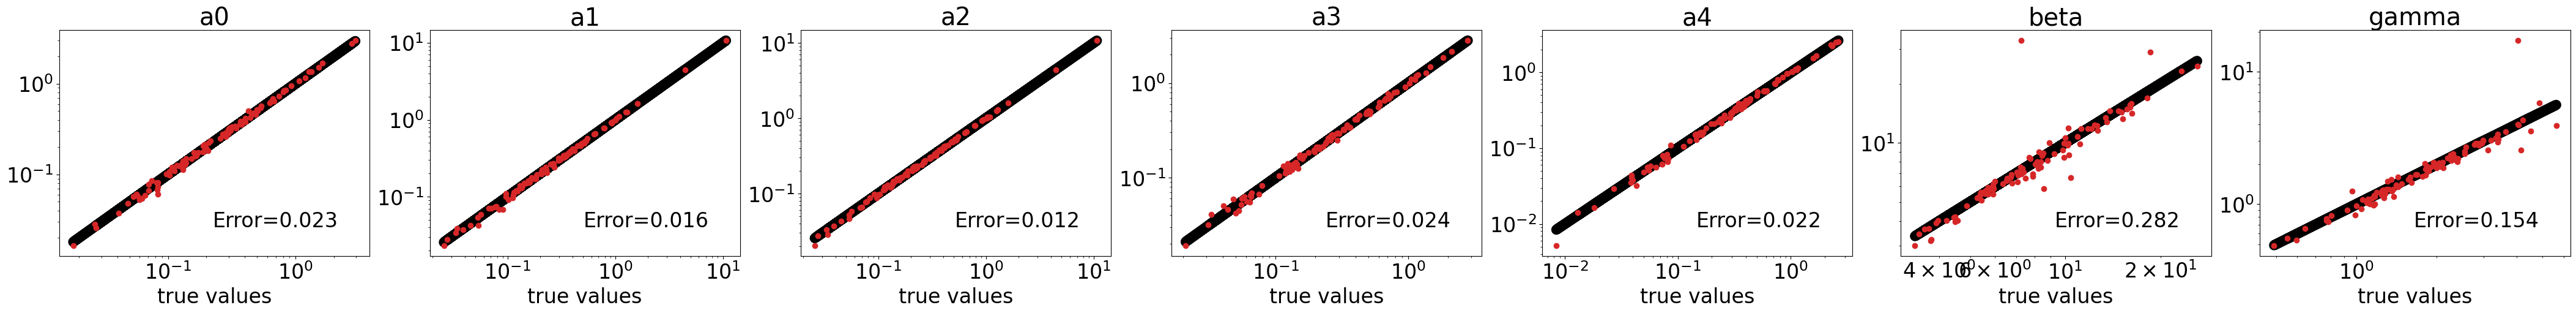

In [34]:
ax = plot_theta(true_theta[:100,[0,1,1,3,2,-2,-1]], traj.theta[:100,[0,1,2,3,4,-2,-1]], dot_color='tab:red')

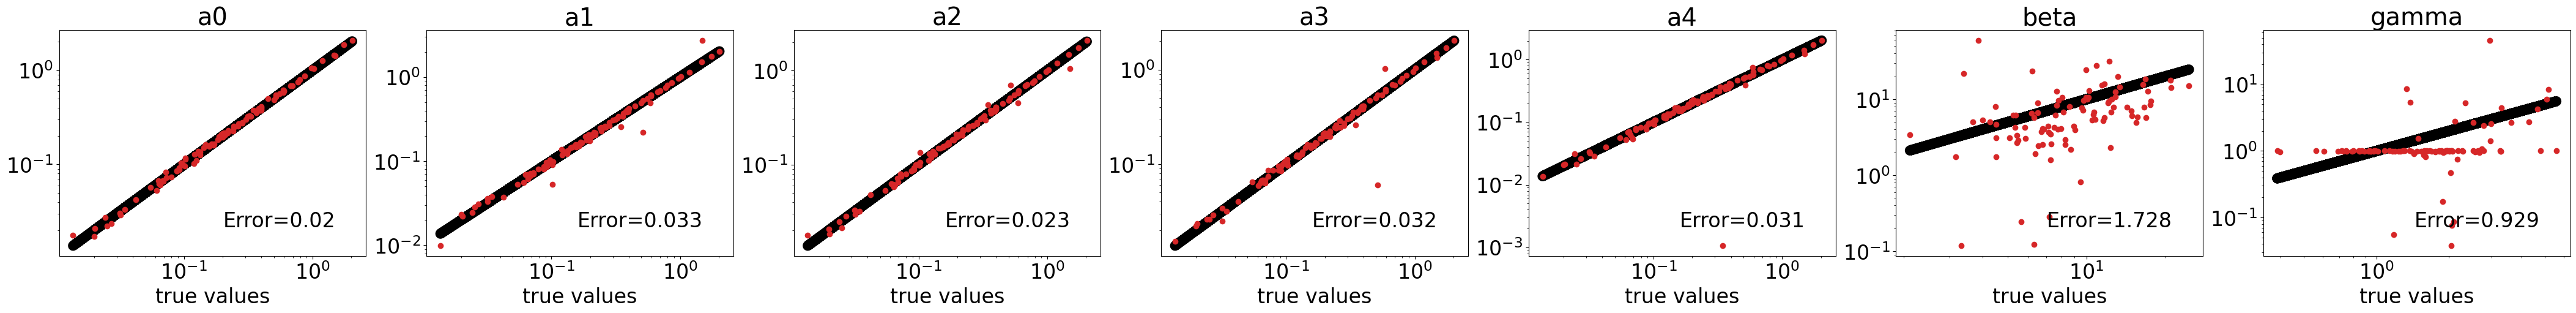

In [35]:
ax = plot_theta(true_theta[100:,[0,1,1,2,3,-2,-1]], traj.theta[100:,[0,1,2,3,4,-2,-1]], dot_color='tab:red')

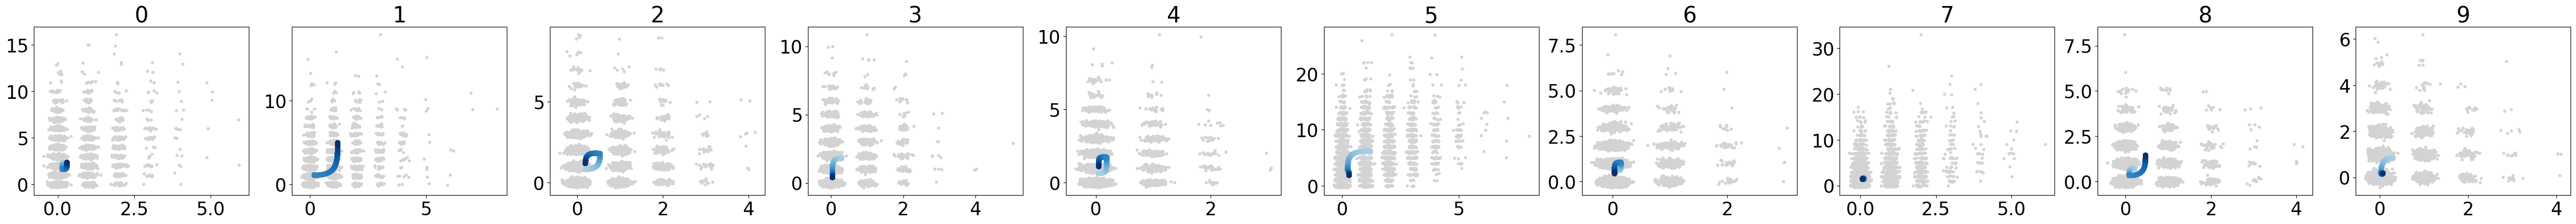

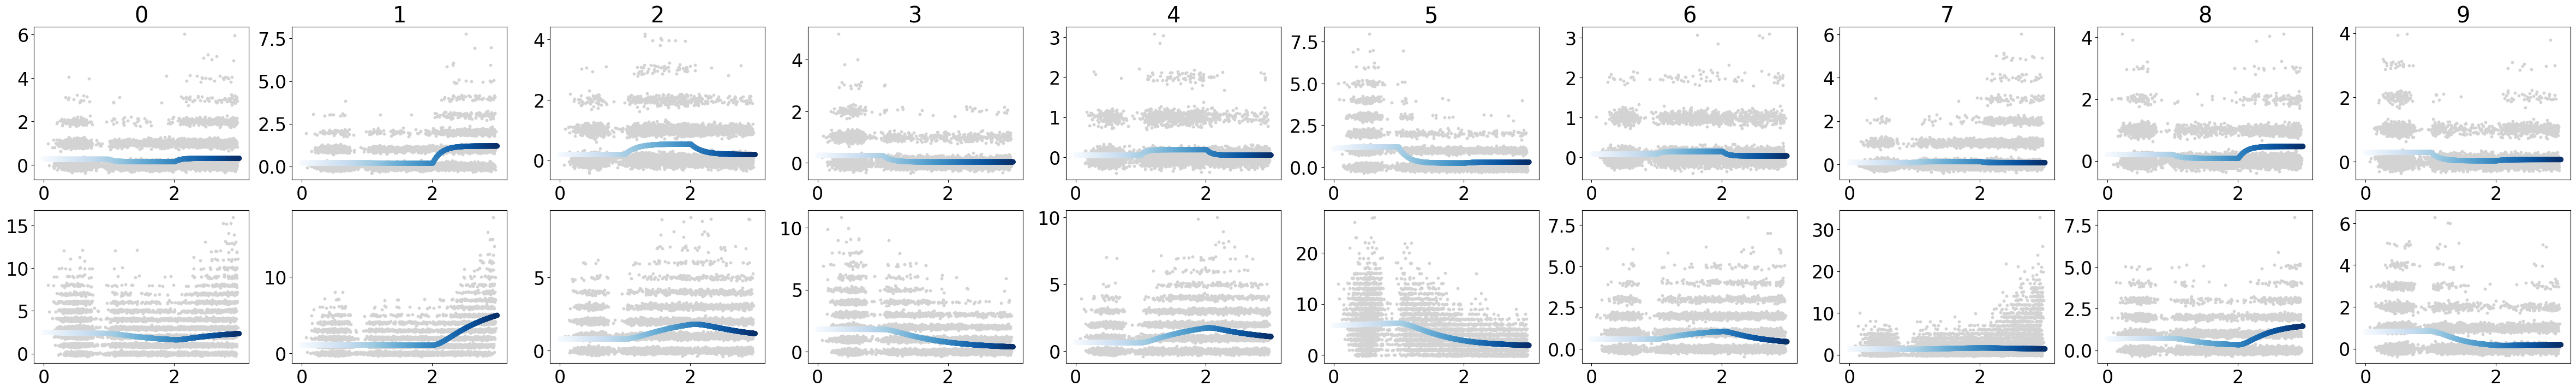

In [43]:
plot_phase(traj,l=0);
plot_y(traj);

# ELBO plot

In [36]:
r = rd/rd_mu
complete_L = np.mean((X*np.log(r[:,None,None]*Y)-r[:,None,None]*Y-gammaln(X+1)).sum(axis=(-1,-2)))
complete_L

-388.9545033886707

In [37]:
theta = true_theta.copy()
traj_true = Trajectory(true_topo, true_tau, model="two_species_ss", verbose=1)
traj_true = traj_true.fit(X,warm_start=True,theta=true_theta,fit_tau=False,norm_Q=True,params={"r":rd/rd.mean()},epoch=0,parallel=False,n_threads=1)
true_L = traj_true.elbos
true_L

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


0it [00:00, ?it/s]


[-391.1752471510005]

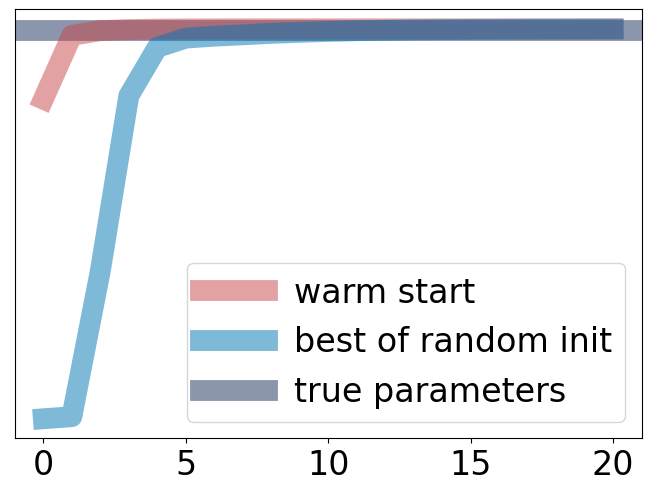

In [83]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.8))

ax.plot(traj_ws.elbos[:21],'-',linewidth=15,markersize=30,label='warm start',color='#c74546',alpha=0.5)
ax.plot(traj.elbos[0][:21],'-',linewidth=15,markersize=30,label='best of random init',color='#0074b3',alpha=0.5)

ax.axhline(y=true_L,ls='-',linewidth=15,color='#8b96ad',label='true parameters',zorder=0)
#ax.axhline(y=complete_L,ls='--',color='rosybrown',label='complete data likelihood')

#ax.set_xlabel('Iterations')
ax.axes.get_yaxis().set_visible(False)
#ax.set_ylabel('ELBO',fontsize=24);
plt.legend(loc="lower right",fontsize=legend_font);

# PCA plots

In [84]:
color_palette = ["#d1e2e5","#BAD4D8","#a2c5ca","#74A8AF","#458b94","#2a606b","#0e3442"]
cmap_teal = colors.LinearSegmentedColormap.from_list("Teals", color_palette, N=7)

In [85]:
cmap_state_1 = cmr.get_sub_cmap('Greys', 0.2, 1)
cmap_state_2 = cmr.get_sub_cmap('Purples', 0.2, 1)
cmap_state_3 = cmr.get_sub_cmap('Blues', 0.2, 1)
cmap_state_4 = cmr.get_sub_cmap('Reds', 0.2, 1)

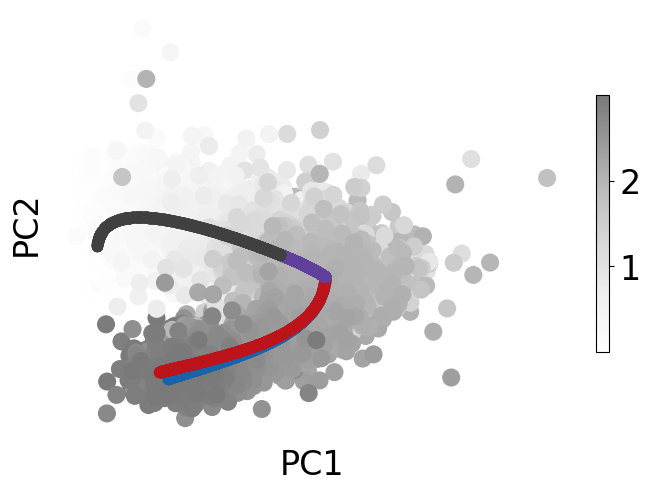

In [86]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.reshape(len(X),-1)/r[:,None])
Y_pca = pca.transform(Y.reshape(len(Y),-1))

cmap_t = cmr.get_sub_cmap('Greys', 0, 0.6)
fig, ax = plt.subplots(1,1)
im=ax.scatter(X_pca[:,0],X_pca[:,1],c=true_t,cmap=cmap_t);

#ax.scatter(Y_pca[(true_t > 1)&(true_t <= 2),0],Y_pca[(true_t > 1)&(true_t <= 2),1],s=100,color='w');
#ax.scatter(Y_pca[(true_t>2) & (np.arange(n)>=n//L),0],Y_pca[(true_t>2) & (np.arange(n)>=n//L),1],s=100,color='w');
#ax.scatter(Y_pca[(true_t>2) & (np.arange(n)<n//L),0],Y_pca[(true_t>2) & (np.arange(n)<n//L),1],s=100,color='w');
n = 5000

idx = (true_t>2) & (np.arange(2*n)>=n)
ax.scatter(Y_pca[idx,0],Y_pca[idx,1],s=50,color=cmap_state_3(0.75)) #true_t[idx],cmap=cmap_state_4);

idx = (true_t>2) & (np.arange(2*n)<n)
ax.scatter(Y_pca[idx,0],Y_pca[idx,1],s=50,color=cmap_state_4(0.75)) #true_t[idx],cmap=cmap_state_3);

idx = (true_t <= 2) & (true_t > 1)
ax.scatter(Y_pca[idx,0],Y_pca[idx,1],s=50,color=cmap_state_2(0.75)) #true_t[idx],cmap=cmap_state_2);

idx = true_t <= 1
ax.scatter(Y_pca[idx,0],Y_pca[idx,1],s=50,color=cmap_state_1(0.75)) #true_t[idx],cmap=cmap_state_1);

ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)

plt.colorbar(im,fraction=0.05, shrink=0.6) # adding the colobar on the right
plt.xticks([]);
plt.yticks([]);

# Plot Q

In [87]:
N = 1e4

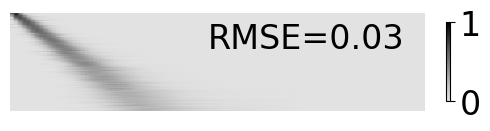

In [162]:
import matplotlib.colors as colors
def _forward(x):
    return np.log(0.05+x)

def _inverse(x):
    return np.exp(x)-0.05

norm = colors.FuncNorm((_forward, _inverse), vmin=0, vmax=1)

color_palette = ['#d1e2e5','#458b94']
cmap_Q = colors.LinearSegmentedColormap.from_list("my_cmap", color_palette, N=1000)

plt.rcParams['font.size'] = '24'
fig, ax = plt.subplots(1,1,figsize=(4.8,1.2))

cell_idx = (true_t<1)
cell_order = np.argsort(true_t[cell_idx])
Z = traj.Q[cell_idx,0,:] + traj.Q[cell_idx,1,:]
im = ax.imshow(Z[cell_order ],aspect="auto",cmap=cmap_state_1, norm=norm);

t_hat=traj.Q.sum(1)@traj.t
ax.text(0.95, 0.9, "RMSE="+str(np.around(np.sqrt(((t_hat[cell_idx]- true_t[cell_idx])/traj.tau[-1])**2).mean(),2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=24);
cbar = plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
ax.axis('off');

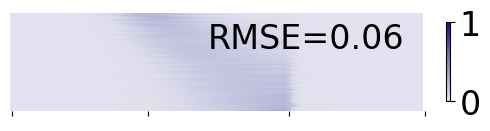

In [89]:
fig, ax = plt.subplots(1,1,figsize=(4.8,1.2))

color_palette = ['#A2C5CA','#0e3442']
cmap_Q = colors.LinearSegmentedColormap.from_list("my_cmap", color_palette, N=1000)

cell_idx = (true_t>=1) & (true_t<2)
t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
Z = traj.Q[cell_idx,0,:] + traj.Q[cell_idx,1,:]
im = ax.imshow(Z[np.argsort(true_t[cell_idx])],aspect="auto",cmap=cmap_state_2, norm=norm);
ax.text(0.95, 0.9, "RMSE="+str(np.around(np.sqrt(((t_hat[cell_idx]- true_t[cell_idx])/traj.tau[-1])**2).mean(),2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=24);
plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = []
ax.set_xticks([0,33,67,100])
ax.set_xticklabels(x_label_list)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

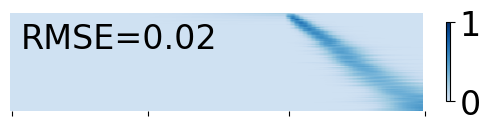

In [90]:
fig, ax = plt.subplots(1,1,figsize=(4.8,1.2))

cell_idx = (true_t>=2) & (np.arange(N)<=N//L)
Z = traj.Q[cell_idx,1,:][np.argsort(true_t[cell_idx])]
im = ax.imshow(Z,aspect="auto",cmap=cmap_state_3, norm=norm);

t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
ax.text(0.5, 0.9, "RMSE="+str(np.around(np.sqrt(((t_hat[cell_idx]- true_t[cell_idx])/traj.tau[-1])**2).mean(),2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=24);
plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = []
ax.set_xticks([0,33,67,100])
ax.set_xticklabels(x_label_list)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

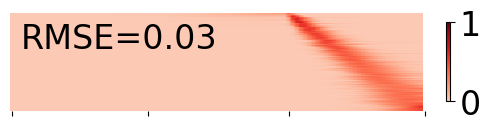

In [91]:
fig, ax = plt.subplots(1,1,figsize=(4.8,1.2))

cell_idx = (true_t>=2) & (np.arange(N)>=N//L)
Z = traj.Q[cell_idx,0,:][np.argsort(true_t[cell_idx])]
im = ax.imshow(Z,aspect="auto",cmap=cmap_state_4, norm=norm);

t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
ax.text(0.5, 0.9, "RMSE="+str(np.around(np.sqrt(((t_hat[cell_idx]- true_t[cell_idx])/traj.tau[-1])**2).mean(),2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=24);
plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = []
ax.set_xticks([0,33,67,100])
ax.set_xticklabels(x_label_list)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

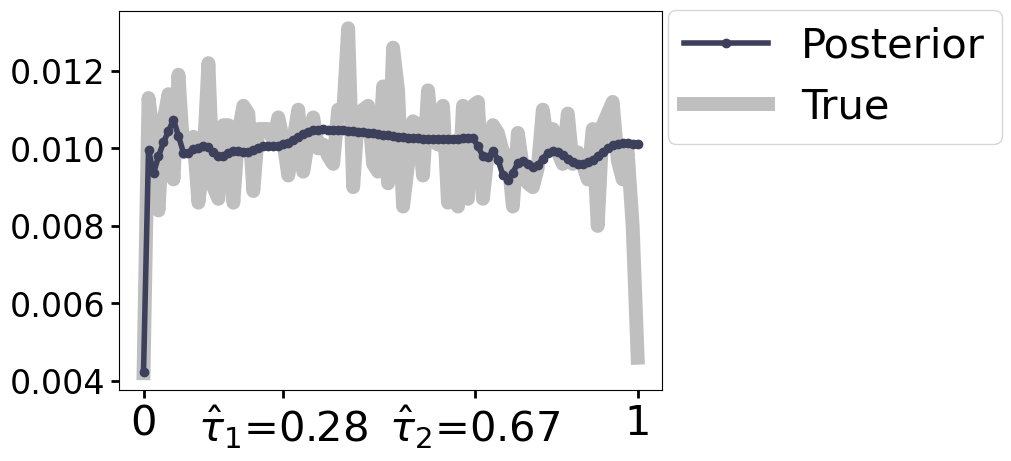

In [92]:
fig,ax = plt.subplots(figsize=(10,4.5))
ax.plot(traj.t,traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=4,label='Posterior');
t_intv = traj.tau[-1]-traj.tau[0]
grid_size = t_intv/(traj.m-1)
hist, bin_edges = np.histogram(true_t,bins=np.linspace(traj.tau[0],traj.tau[-1]+grid_size,traj.m+1)-grid_size/2,density=True)
ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist*grid_size,color='gray',linewidth=10,alpha=0.5,zorder=0,label='True')

x_label_list = ['0', r'$\hat{\tau}_1$='+str(np.around(traj.tau[1]/traj.tau[-1],2)),r'$\hat{\tau}_2$='+str(np.around(traj.tau[2]/traj.tau[-1],2)), '1']
ax.tick_params(direction='out', length=6, width=2)
ax.set_xticks(traj.tau)
ax.set_xticklabels(x_label_list,fontsize=30)
ax.legend(loc=(1.01,0.65),fontsize=label_font)

# Plot theta

In [257]:
def plot_theta_ss(theta,theta_hat,dot_color='grey'):
    n_theta=np.shape(theta)[1]
    fig, ax = plt.subplots(1,n_theta,figsize=(n_theta*5,4),constrained_layout=True)

    for i in range(n_theta):
        ax[i].plot(theta[:,i],theta[:,i],color='lightgray',zorder=0);
        ax[i].scatter(theta[:,i],theta_hat[:,i],color=dot_color);
        if i < n_theta-2:
            ax[i].text(0.95, 0.2, "Error="+str(np.around(np.mean(np.abs(theta_hat[:,i]-theta[:,i])/np.sqrt(theta[:,i])),3)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax[i].transAxes, color="black",fontsize=32);
        else:
            ax[i].text(0.95, 0.2, "Error="+str(np.around(np.mean(np.abs(theta_hat[:,i]-theta[:,i])/theta[:,i]),3)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax[i].transAxes, color="black",fontsize=32);
        #ax[i+1].set_title("α"+str(i+1), fontsize = label_font)
        #ax[i].set_xscale('log')
        #ax[i].set_yscale('log')
    #fig.supxlabel("true values", fontsize = label_font);
    #fig.supylabel("estimates", fontsize = label_font)
    
    return fig

In [264]:
true_theta_ = true_theta[:,[0,1,1,2,3,-2,-1]]
theta_hat = traj_ws.theta.copy()

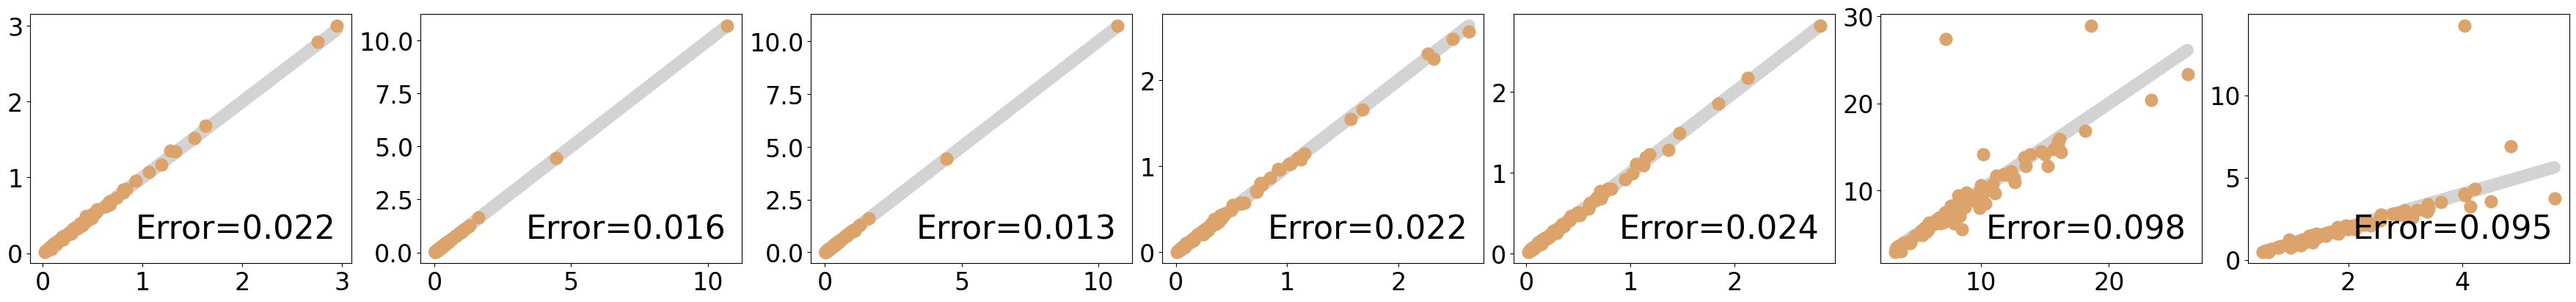

In [265]:
fig = plot_theta_ss(true_theta_[:100,:], theta_hat[:100,:],dot_color='#dca36a')

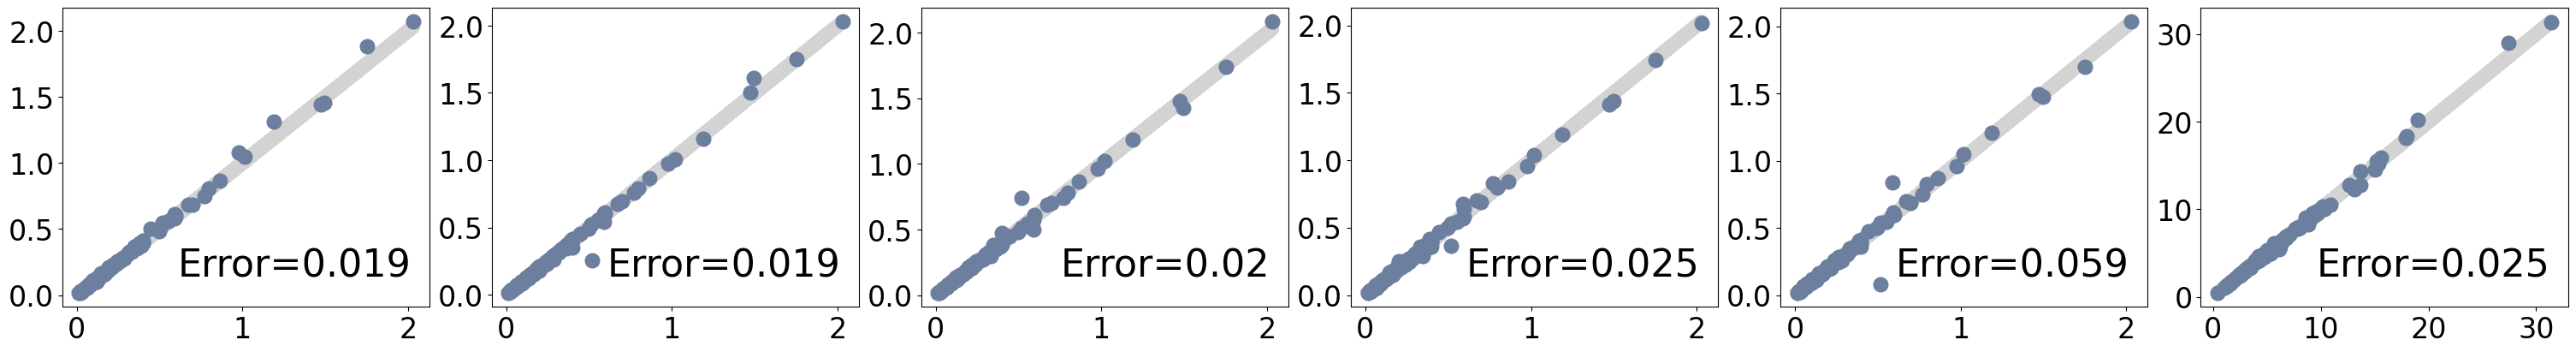

In [266]:
theta_hat[100:,-2] /= theta_hat[100:,-1]
true_theta_[100:,-2] /= true_theta_[100:,-1]
fig = plot_theta_ss(true_theta_[100:,:-1], theta_hat[100:,:-1],dot_color="#6d7f9f")

In [246]:
def plot_theta_AE(theta,true_theta,dot_color='k'):
    p, n_theta = theta.shape
    fig, ax = plt.subplots(1,n_theta,figsize=(n_theta*5,4),constrained_layout=True)
    Q = traj.Q
    topo = traj.topo
    N,p,_ = traj.X.shape
    true_theta_temp = true_theta.copy()
                    
    error = np.abs(theta-true_theta_temp)
    for j in range(n_theta-2):
        ax[j].scatter(true_theta_temp[:,j],error[:,j],color=dot_color);
        
    for j in range(n_theta-2,n_theta):
        ax[j].scatter(true_theta_temp[:,j],error[:,j],color=dot_color);
          
    for j in range(n_theta-2):
        #ax[j].set_title("α"+str(j),fontsize=label_font)  
        #ax[j].loglog(true_theta_temp[:,j],0.1*np.power(true_theta_temp[:,j],1),color='lightgrey',label=r'$0.1x$',zorder=0);
        ax[j].loglog(true_theta_temp[:,j],0.01*np.power(true_theta_temp[:,j],0.5),color='lightblue',label=r'$0.01\sqrt{x}$',zorder=0);
        ax[j].legend(loc='lower right')
    for j in range(n_theta-2,n_theta):
        ax[j].loglog(true_theta_temp[:,j],0.1*np.power(true_theta_temp[:,j],1),color='lightgrey',label=r'$0.1x$',zorder=0);
        ax[j].legend(loc='lower right')

    #ax[-2].set_title("β",fontsize=label_font)
    #ax[-1].set_title("γ",fontsize=label_font)
    
    #fig.supxlabel('True value',fontsize=label_font);
    #fig.supylabel('Absolute error',fontsize=label_font);

    return

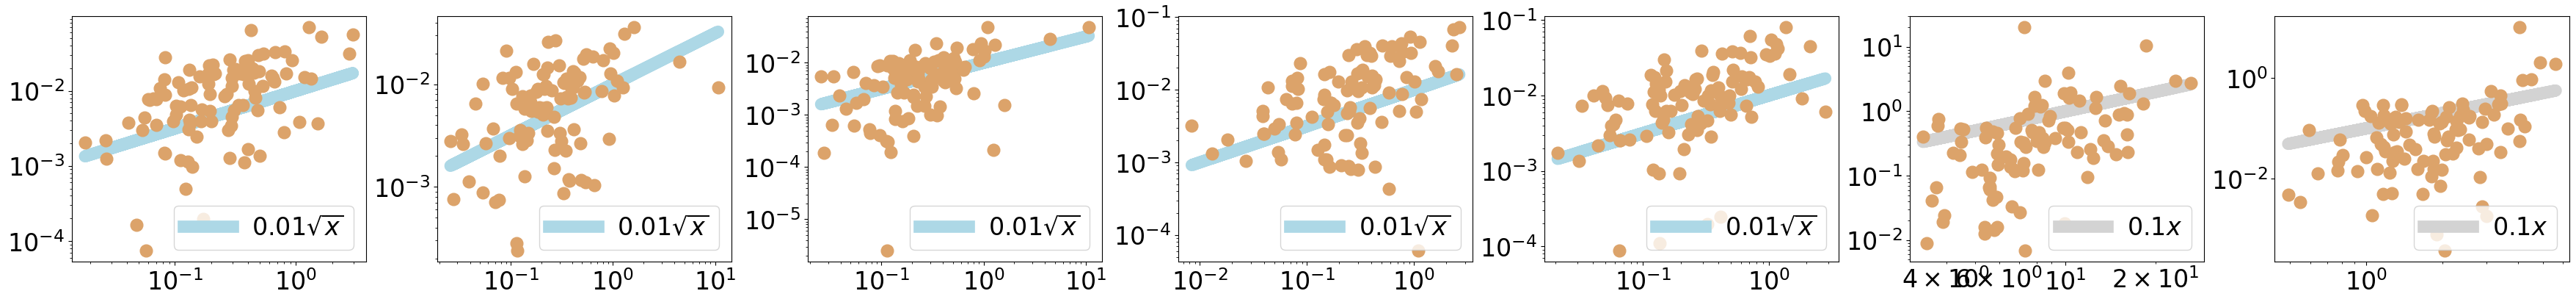

In [267]:
plot_theta_AE(theta_hat[:100],true_theta_[:100],dot_color='#dca36a')

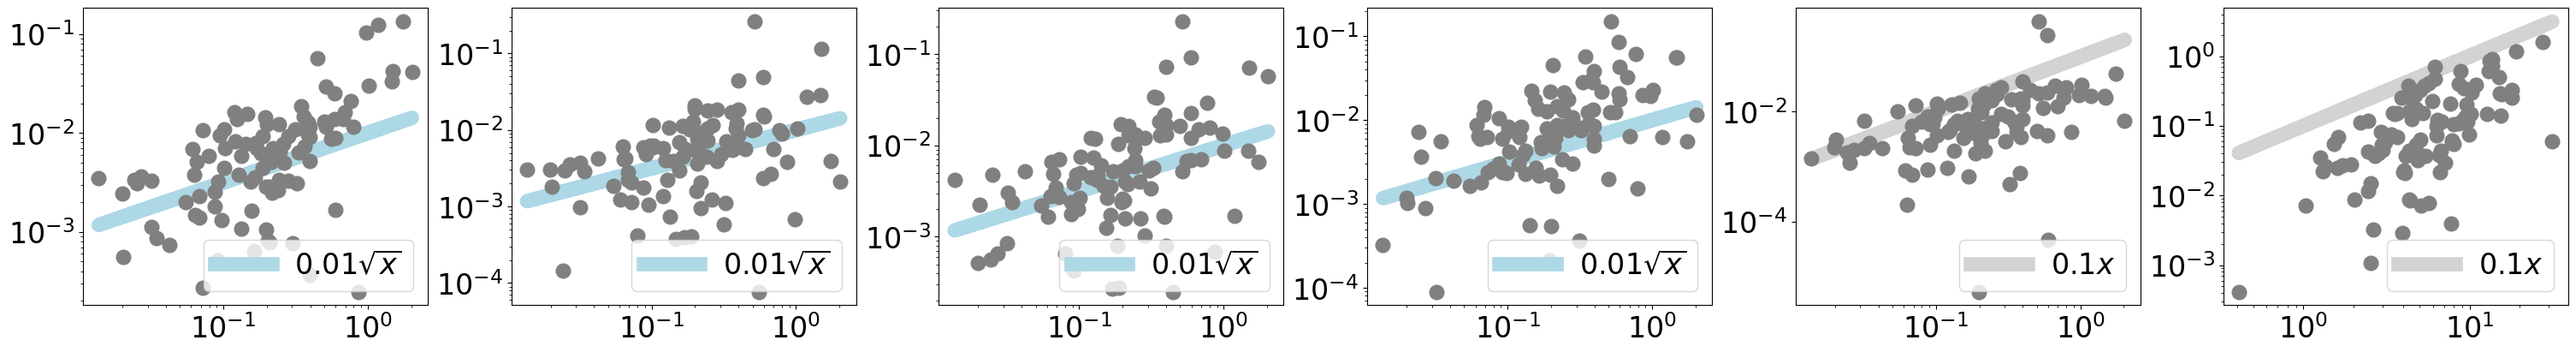

In [268]:
plot_theta_AE(theta_hat[100:,:-1],true_theta_[100:,:-1],dot_color='grey')

# DE genes

[]

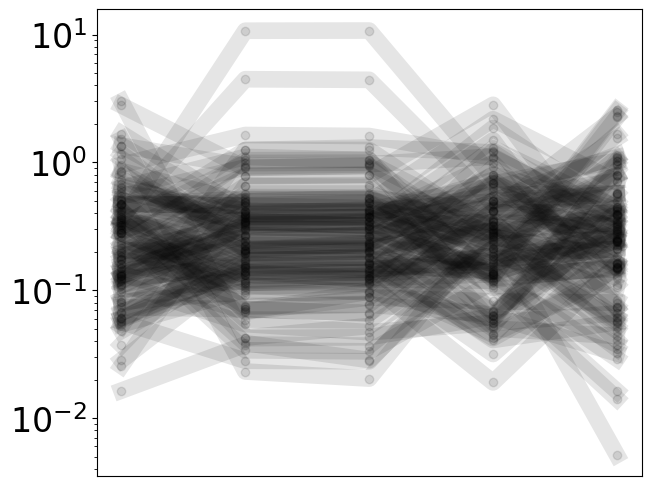

In [144]:
fig,ax = plt.subplots(1,1)
for j in range(100):
    ax.plot(traj.theta[j,[0,1,2,3,4]],'.-',color='k',alpha=0.1)

ax.set_yscale('log')
x_label_list = ['α0', 'α1', 'α2', 'α3', 'α4']
ax.set_xticks([])
#ax.set_xticks([0,1,2,3,4])
#ax.set_xticklabels(x_label_list)

[]

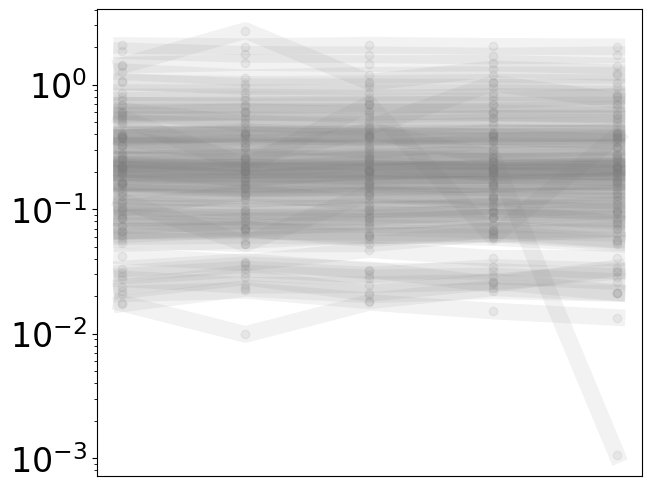

In [145]:
fig,ax = plt.subplots(1,1)
for j in range(100,200):
    ax.plot(traj.theta[j,[0,1,2,3,4]],'.-',color='gray',alpha=0.1)
x_label_list = ['α0', 'α1', 'α2', 'α3', 'α4']
ax.set_yscale('log')
ax.set_xticks([])
#ax.set_xticks([0,1,2,3,4])
#ax.set_xticklabels(x_label_list)

In [150]:
r = traj.params['r']
traj_ = Trajectory(traj.topo, traj.tau, model="two_species_ss", verbose=0)
traj_ = traj_.fit(traj.X,m=100,warm_start=True,params={'r':r},theta=traj.theta,epoch=0,parallel=False,n_threads=1)

gene_logL, KL = traj_.compute_gene_logL(traj.X,traj.Q+1e-10)

In [151]:
gene_logL.sum()+KL

-391.10571886512264

In [152]:
traj_.elbos[-1]

-391.1057102747658

In [153]:
KL

-2.228320545190299

In [154]:
p=200
theta0 = np.ones((p,6))
theta0[:,:-1] = traj.theta[:,:5]
theta0[:,-1] = traj.theta[:,-2]/traj.theta[:,-1]
PMSS = PoissonMixtureSS(n_components=5)
Q, lower_bound = PMSS.fit(traj.X, warm_start=True, theta=theta0, read_depth=r, epoch=10)

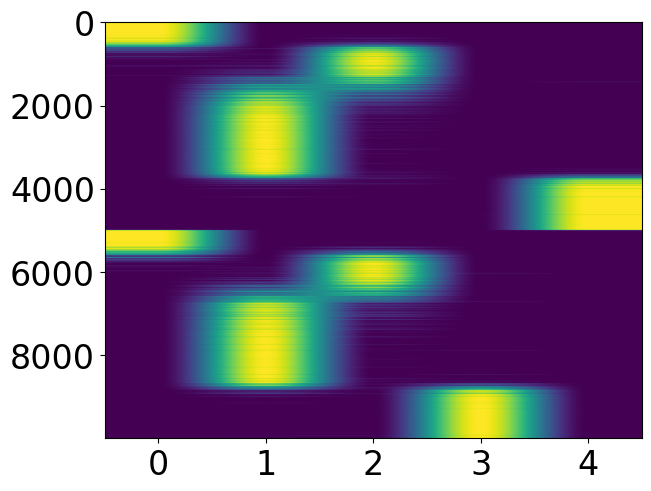

In [155]:
plt.imshow(Q,aspect='auto')

In [156]:
cluster_gene_logL, cluster_KL = PMSS.compute_gene_logL(traj.X,Q)

dlogL = gene_logL - cluster_gene_logL

cluster_KL 

-1.3867189252398295

In [157]:
dH = (cluster_KL-KL)/len(gene_logL)
good_mask = (dlogL>dH) 
good_idx = np.arange(p)[good_mask]
print(len(good_idx))
good_idx

91


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       38, 39, 40, 41, 44, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93,
       94, 95, 96, 97, 98, 99])

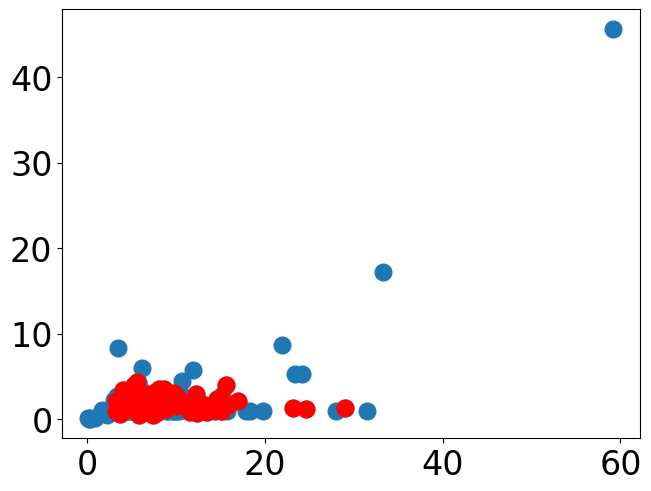

In [158]:
plt.scatter(traj.theta[:,-2],traj.theta[:,-1])
plt.scatter(traj.theta[good_idx,-2],traj.theta[good_idx,-1],color='r')

[]

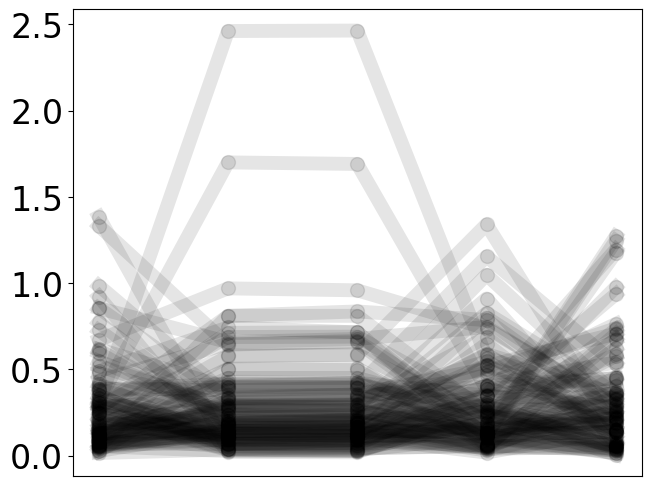

In [275]:
fig,ax = plt.subplots(1,1)
for j in good_idx:
    ax.plot(np.log1p(traj.theta[j,[0,1,2,3,4]]),'.-',linewidth=10,markersize=20,color='k',alpha=0.1)

x_label_list = ['α0', 'α1', 'α2', 'α3', 'α4']
ax.set_xticks([])
#ax.set_xticks([0,1,2,3,4])
#ax.set_xticklabels(x_label_list)

In [161]:
alpha = traj.theta[good_idx,:5]
DE_idx = np.arange(200)[good_idx][np.max(alpha,axis=1)/np.min(alpha,axis=1) > 2]
DE_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       38, 39, 40, 41, 44, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99])

# Fisher information matrix

In [163]:
from RADOM.models.two_species_ss import get_y_jac

def get_Y_jac(topo, tau, m, theta):    
    L=len(topo)
    n_states=len(set(topo.flatten()))
    p,n_theta = theta.shape
    Y_grids = np.zeros((L,m,p,2))
    dY_grids_dtheta = np.zeros((L,m,p,2,n_theta))
    t=np.linspace(tau[0],tau[-1],m)
    for l in range(L):
        theta_idx = np.append(topo[l],[-2,-1])
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
        for j in range(p):
            y, dy_dtheta = get_y_jac(theta_l[j],t,tau) # m*2*len(theta)
            Y_grids[l,:,j] = y # m*2
            dY_grids_dtheta[l,:,j,:][:,:,theta_idx] = dy_dtheta
    return Y_grids, dY_grids_dtheta

In [164]:
eps = 1e-6

def compute_FI(Y,dY_dtheta,X,weights=None):
    L,m,p = Y.shape[:3]
    logL = np.sum(X[:,None,None,:,:]*np.log(Y[None,:]+eps)-Y[None,:],axis=(-2,-1))  # size (n,L,m,p,2)
    #logL += - np.log(m) - np.log(L)
    if weights is not None:
        logL += np.log(weights)
    Q = softmax(logL, axis=(-2,-1))
    
    # jac_temp: (n,L,m,p,2,n_theta) -> (n,L,m,p,n_theta)
    jac_temp = np.sum((X[:,None,None,:,:,None]/Y[None,:,:,:,:,None]-1)*dY_dtheta[None,:],axis=(-2)) 
    jac_temp *= Q[:,:,:,None,None]
    jac_temp = np.sum(jac_temp,axis=(1,2)) #(n,p,n_theta)
    FI = np.sum(jac_temp[:,:,:,None]*jac_temp[:,:,None,:],axis=0)
    return Q,FI

In [202]:
Y_grids,dY_grids_dtheta = get_Y_jac(topo, tau, m=100, theta=true_theta[:,[0,0,1,2,3,-2,-1]])
Y_ = np.concatenate([Y_grids[0],Y_grids[1]])
FI_X = np.random.poisson(Y_,size=(5, 200, 200, 2))
FI_X = FI_X.reshape((1000, 200, 2))
Q, FIM = compute_FI(Y_grids,dY_grids_dtheta,FI_X)

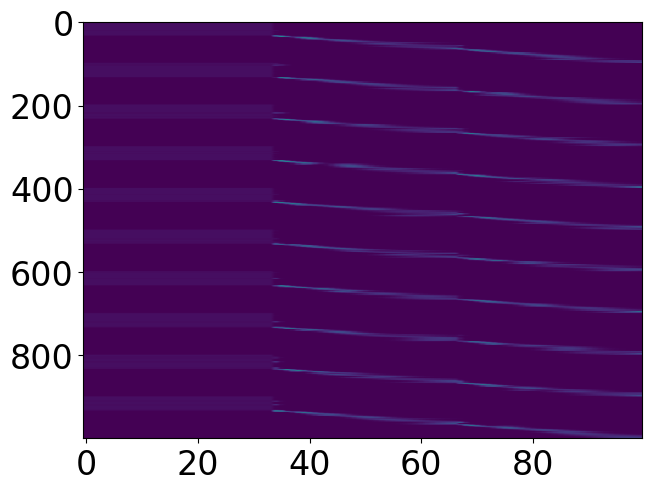

In [203]:
plt.imshow(Q.sum(1),aspect='auto')

In [204]:
w,v = np.linalg.eig(FIM)

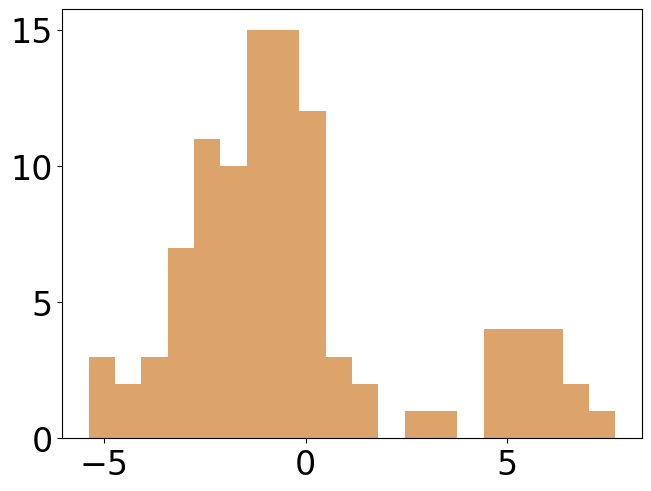

In [205]:
plt.hist(np.log(w[:100,-1]),bins=20,color='#dca36a');

/tmp/ipykernel_887185/2948357940.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(w[100:,-1]),bins=20,color="#6d7f9f");


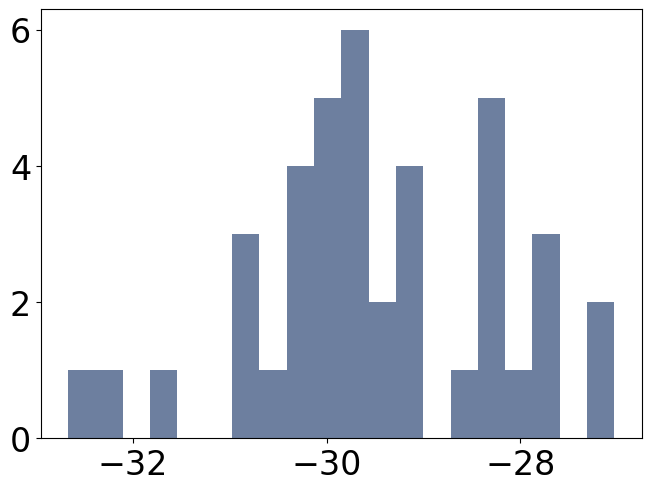

In [206]:
plt.hist(np.log(w[100:,-1]),bins=20,color="#6d7f9f");

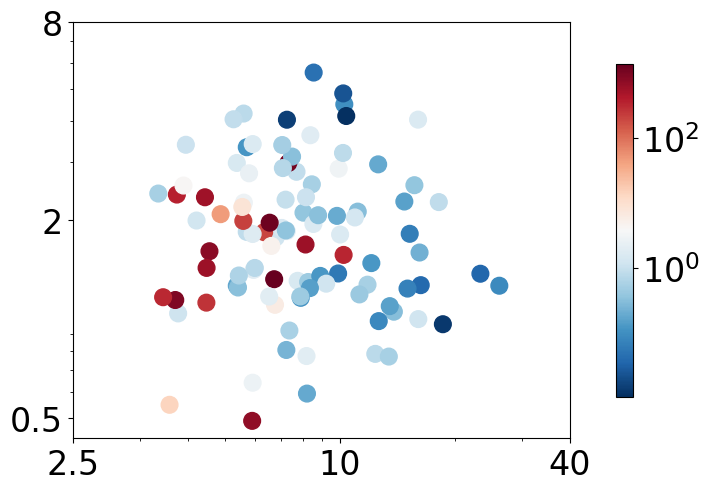

In [212]:
fig,ax = plt.subplots(1,1,figsize=(7,4.8))
im = ax.scatter(true_theta[:100,-2],true_theta[:100,-1],c=w[:100,-1],norm=colors.LogNorm(),alpha=1,cmap='RdBu_r')

ax.set_xscale('log')
ax.set_yscale('log')
x_label_list = [2.5,10,40]
ax.set_xticks([2,10,40])
ax.set_xticklabels(x_label_list)
y_label_list = [0.5, 2, 8]
ax.set_yticks([0.5, 2, 8])
ax.set_yticklabels(y_label_list)

bar = plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right

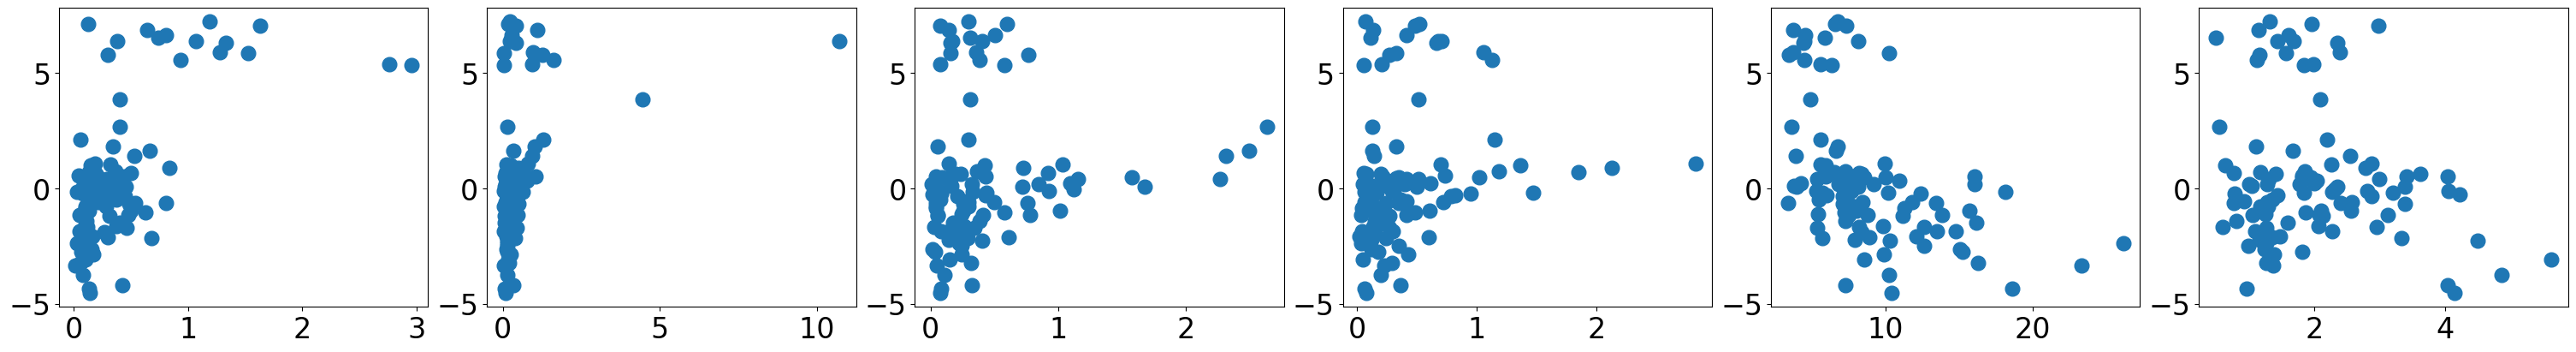

In [211]:
n_theta=np.shape(true_theta)[1]
fig, ax = plt.subplots(1,n_theta,figsize=(n_theta*5,4),constrained_layout=True)

for i in range(n_theta):
    ax[i].scatter(theta[:100,i],np.log(w[:100,-1]));


-391.1057102747658

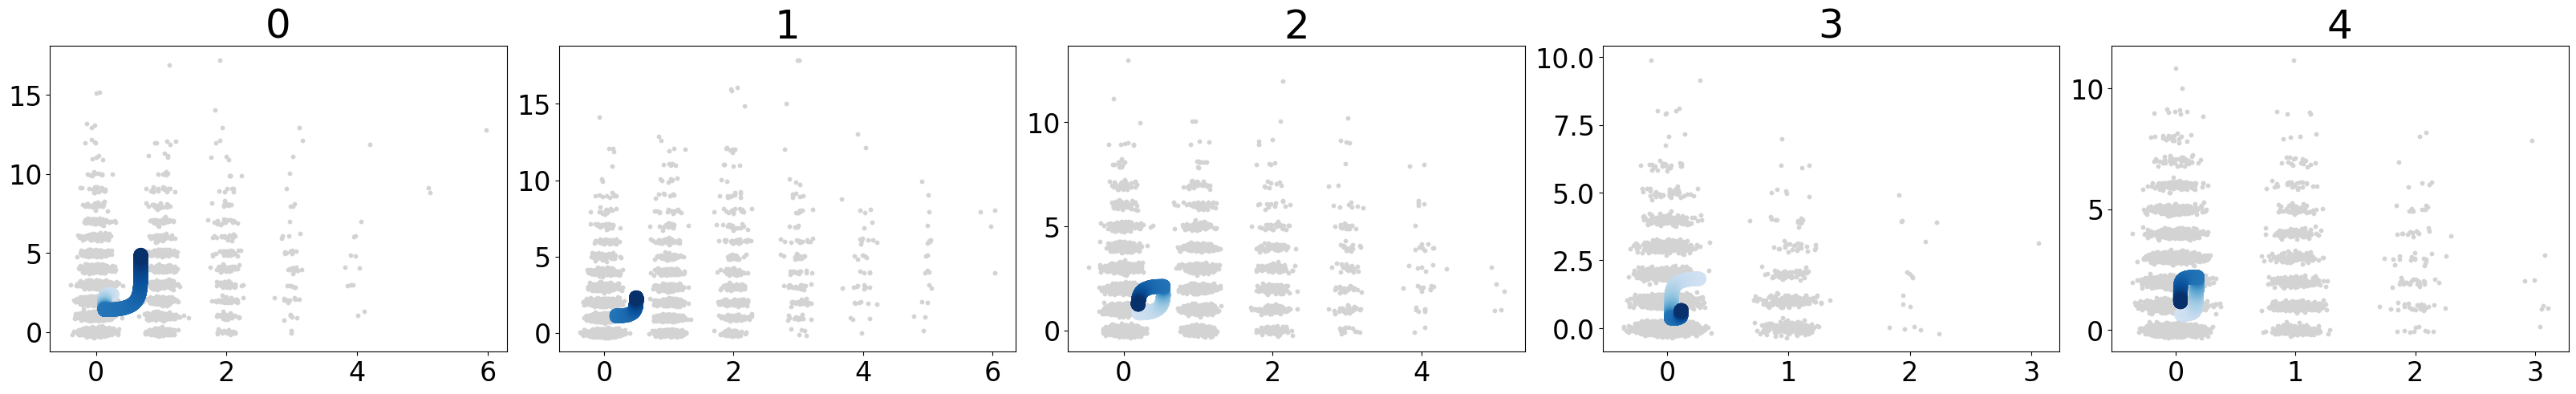

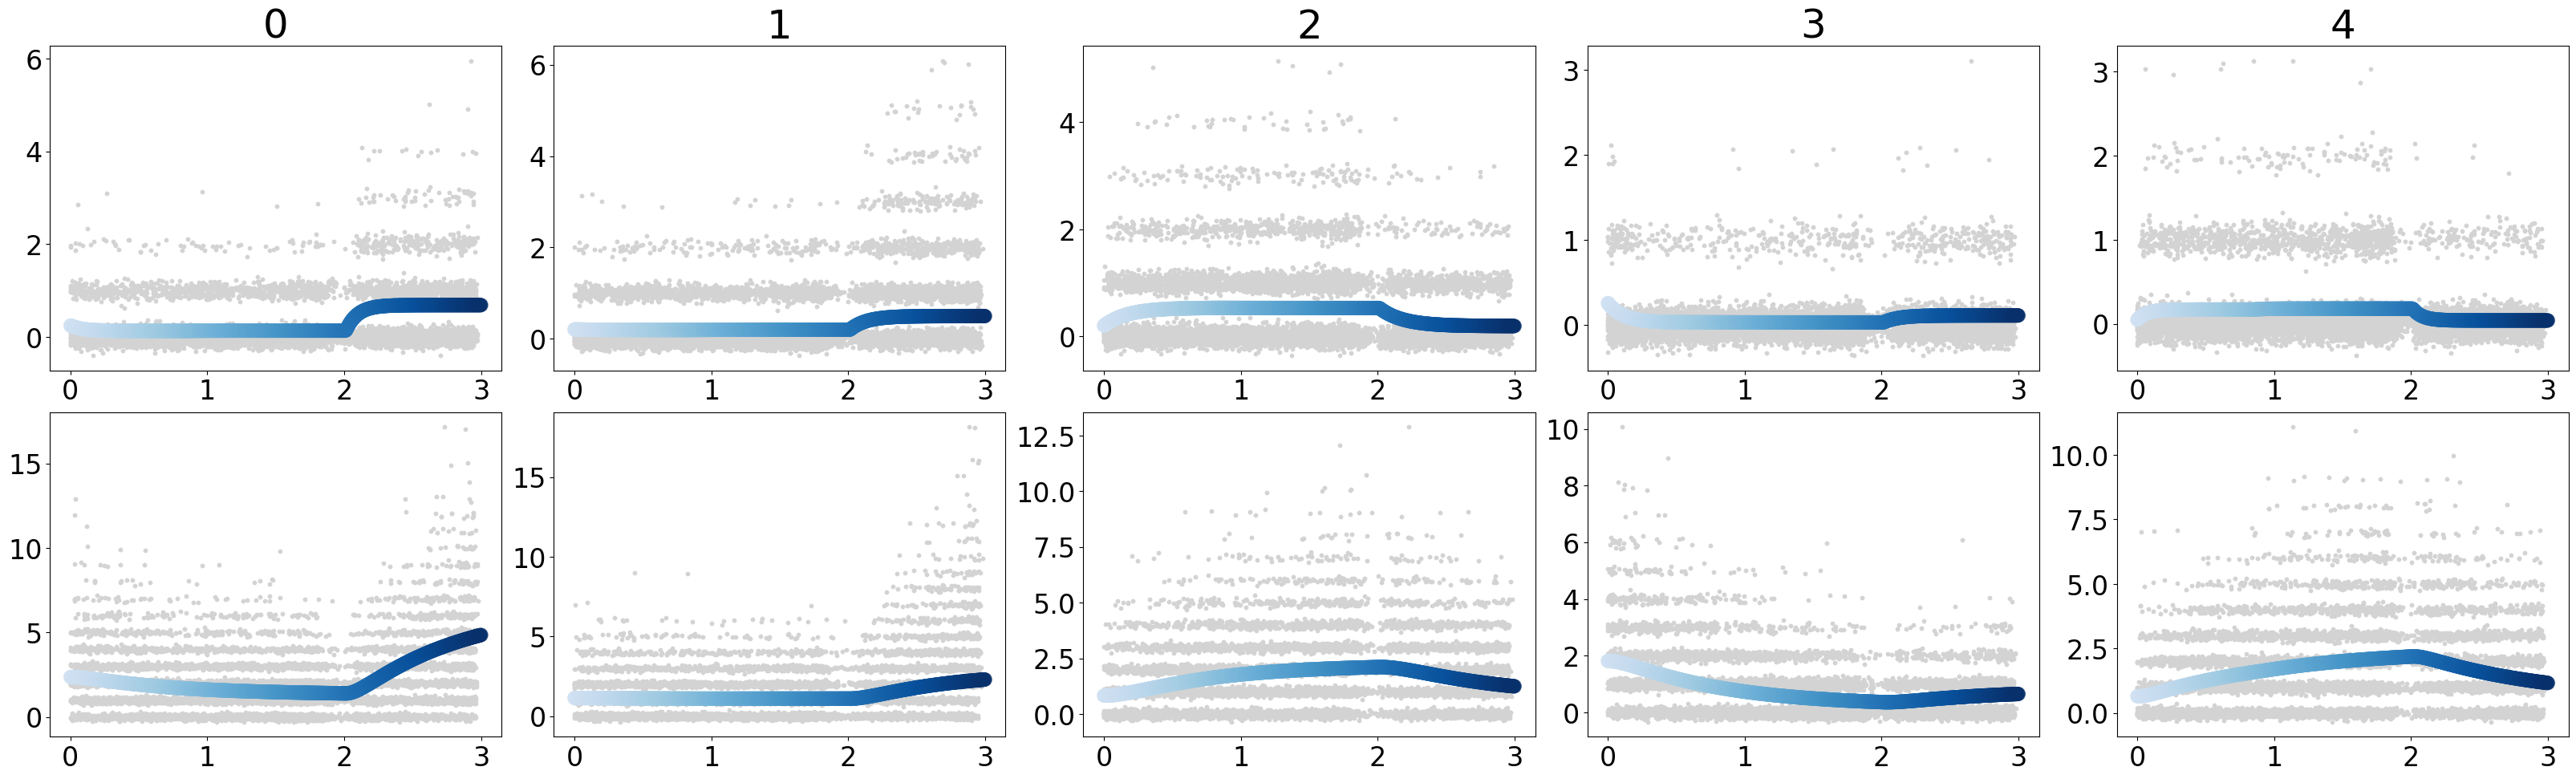

In [132]:
plot_phase(traj,idx=np.arange(5));
plot_y(traj,idx=np.arange(5));
traj.compute_lower_bound(traj.X)

-391.17464107398035

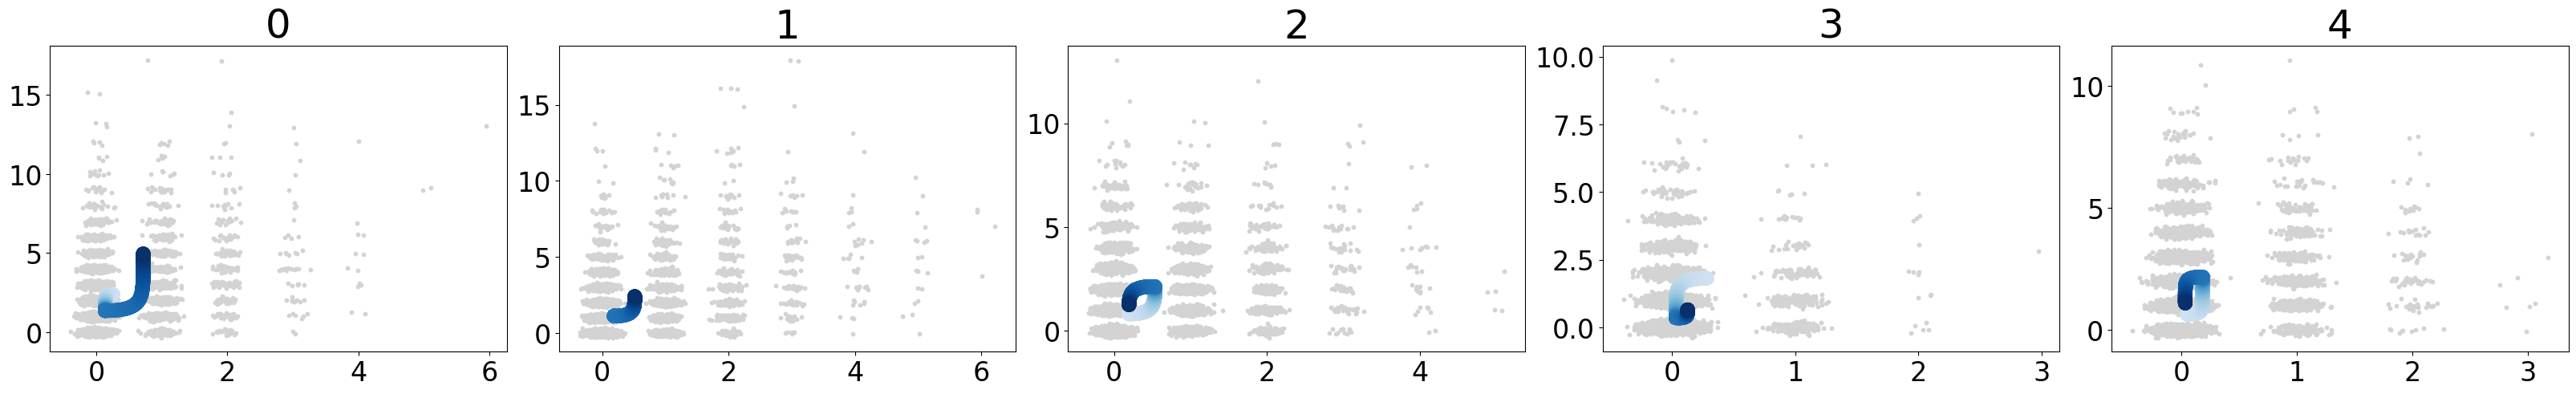

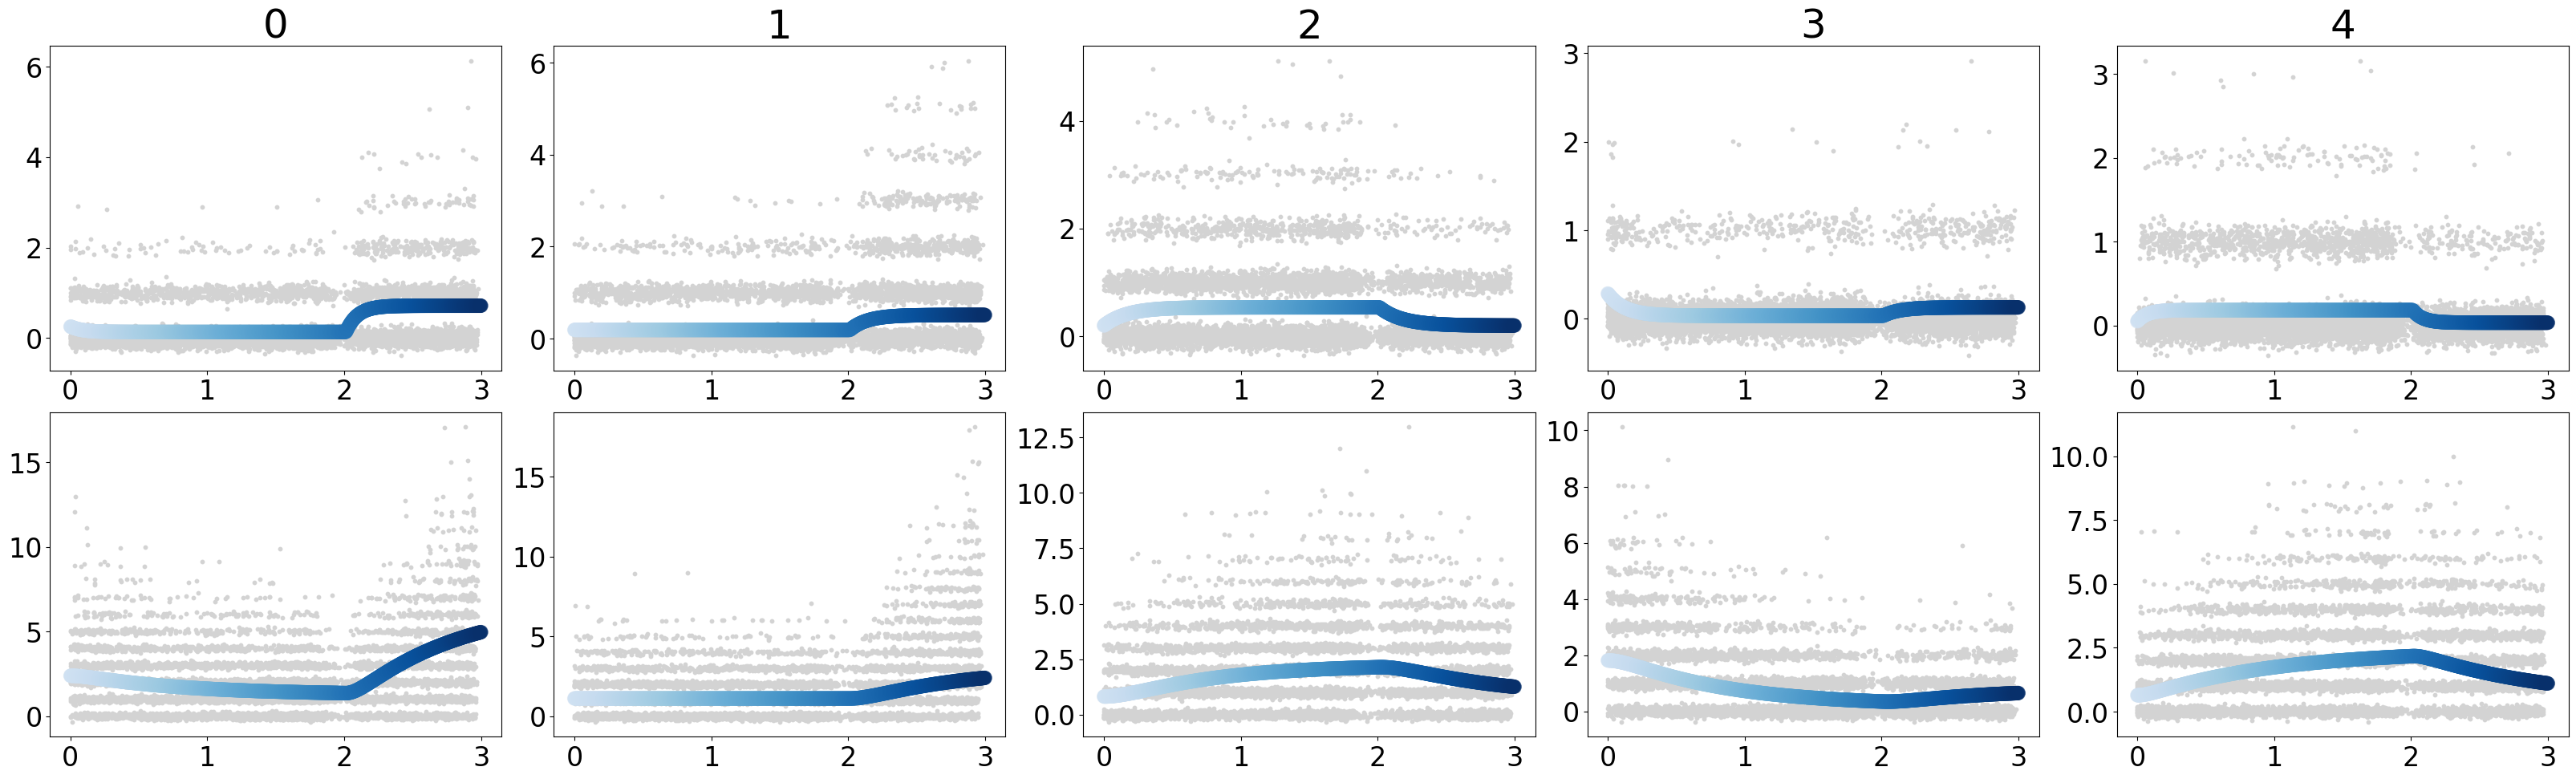

In [158]:
theta0 = true_theta[:,[0,1,1,3,2,-2,-1]]
traj_true = copy.deepcopy(traj)
traj_true.theta = theta0
plot_phase(traj_true,idx=np.arange(5));
plot_y(traj_true,idx=np.arange(5));
traj_true.compute_lower_bound(traj.X)

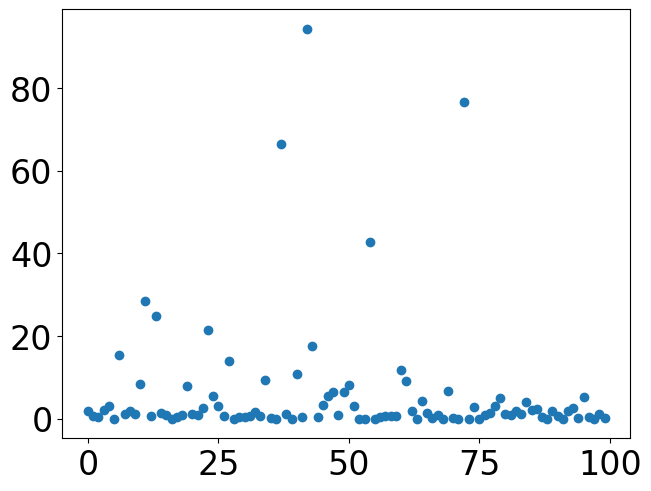

In [159]:
p = traj.theta.shape[0]
step = np.zeros(p)
values = w[:,-1]
step[values>0]=1/np.sqrt(values[values>0])**2
plt.plot(step[:100],'.')

-391.1944807813024

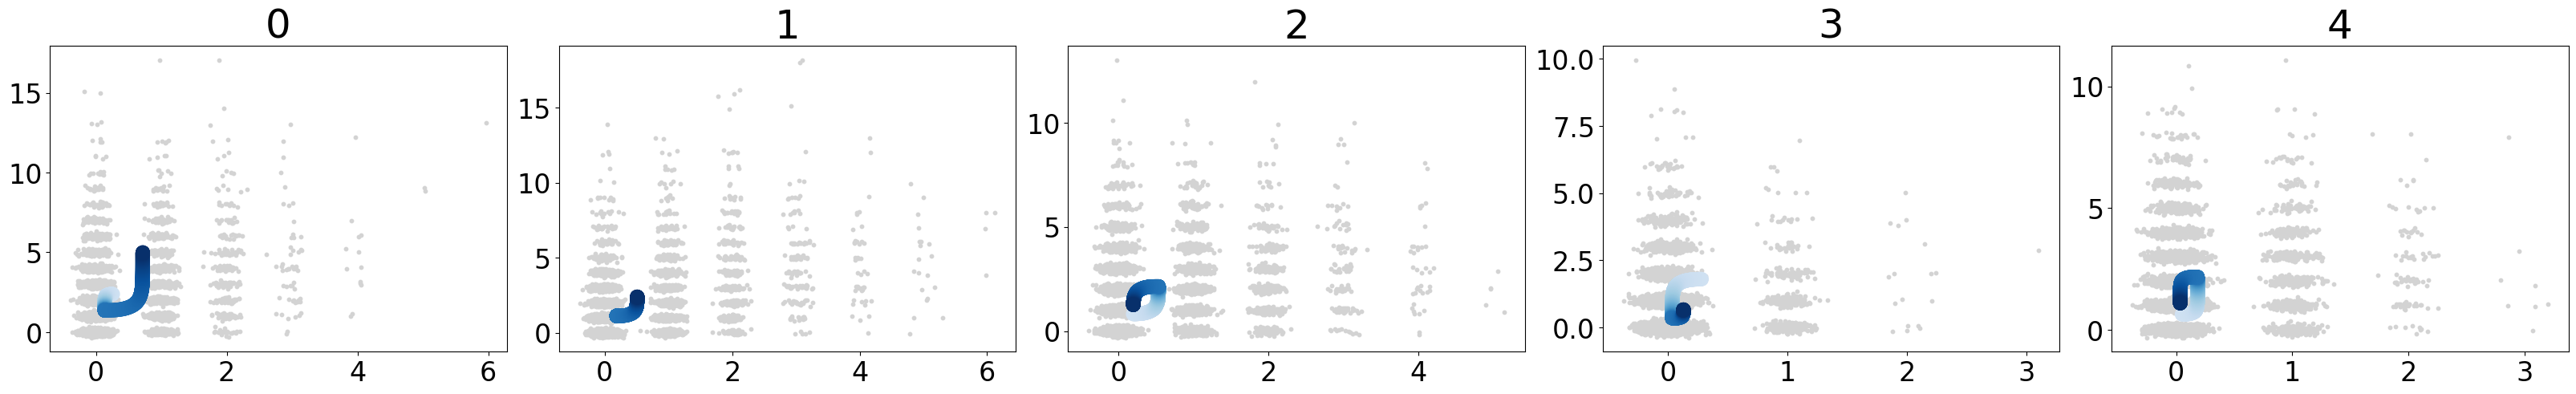

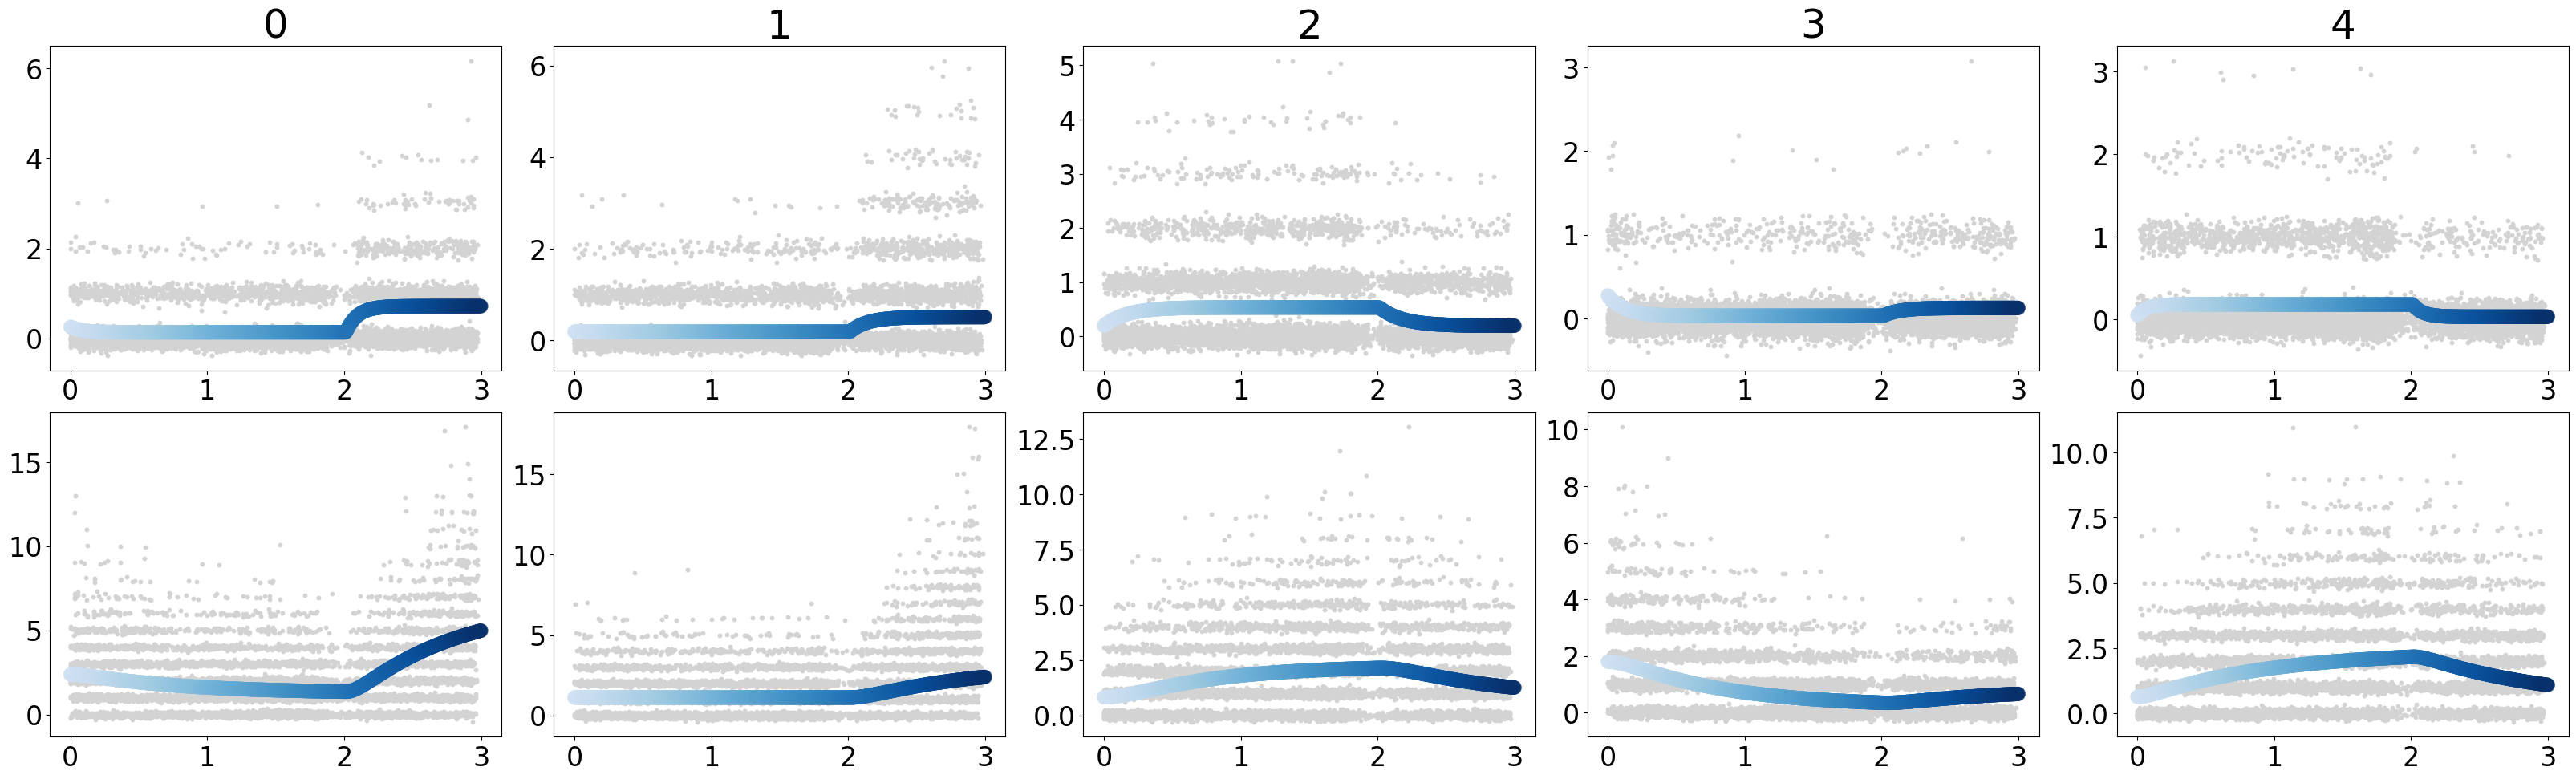

In [204]:
traj_temp = copy.deepcopy(traj_true)
traj_temp.theta[:100] += 0.1*step[:100,None]*v[:100,:,-1]
plot_phase(traj_temp,idx=np.arange(5));
plot_y(traj_temp,idx=np.arange(5));
traj_temp.compute_lower_bound(traj.X)

-391.1935564585713

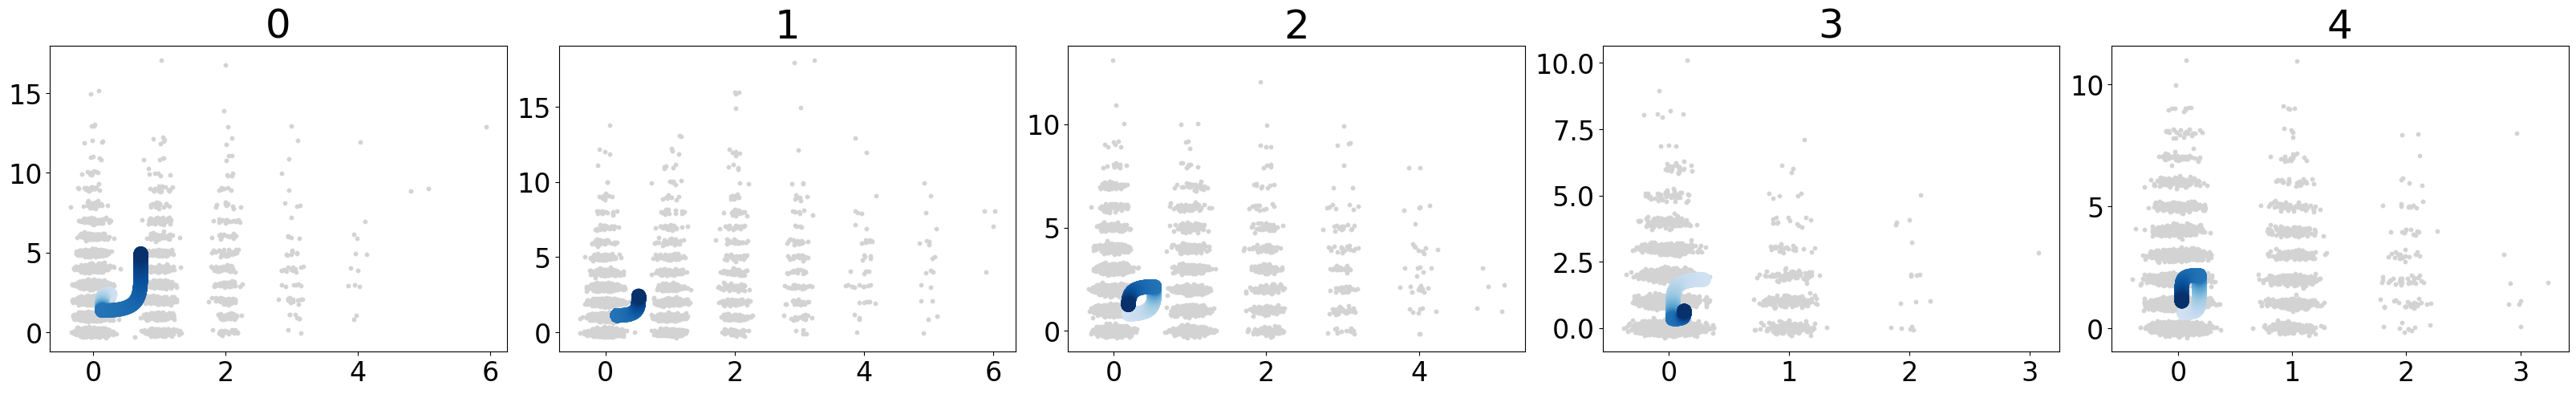

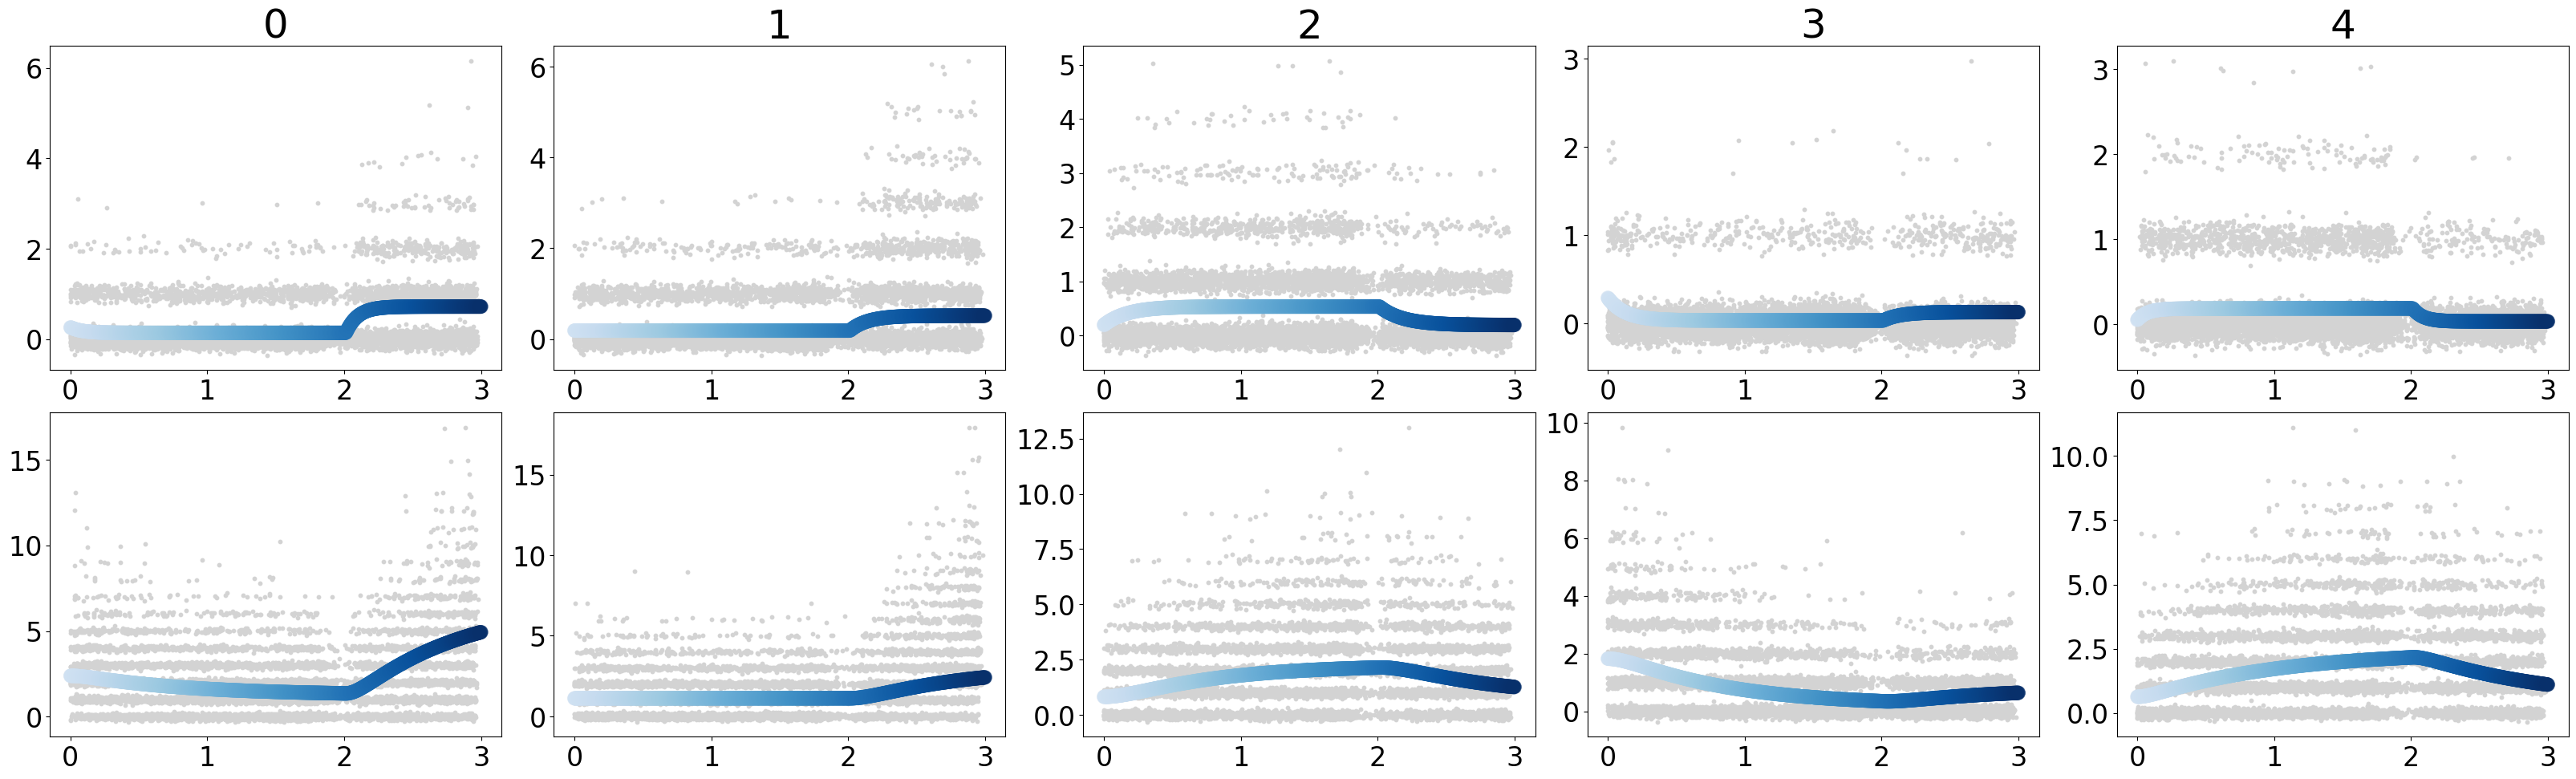

In [205]:
traj_temp2 = copy.deepcopy(traj_true)
traj_temp2.theta[:100] -= 0.1*step[:100,None]*v[:100,:,-1]
plot_phase(traj_temp2,idx=np.arange(5));
plot_y(traj_temp2,idx=np.arange(5));
traj_temp2.compute_lower_bound(traj.X)

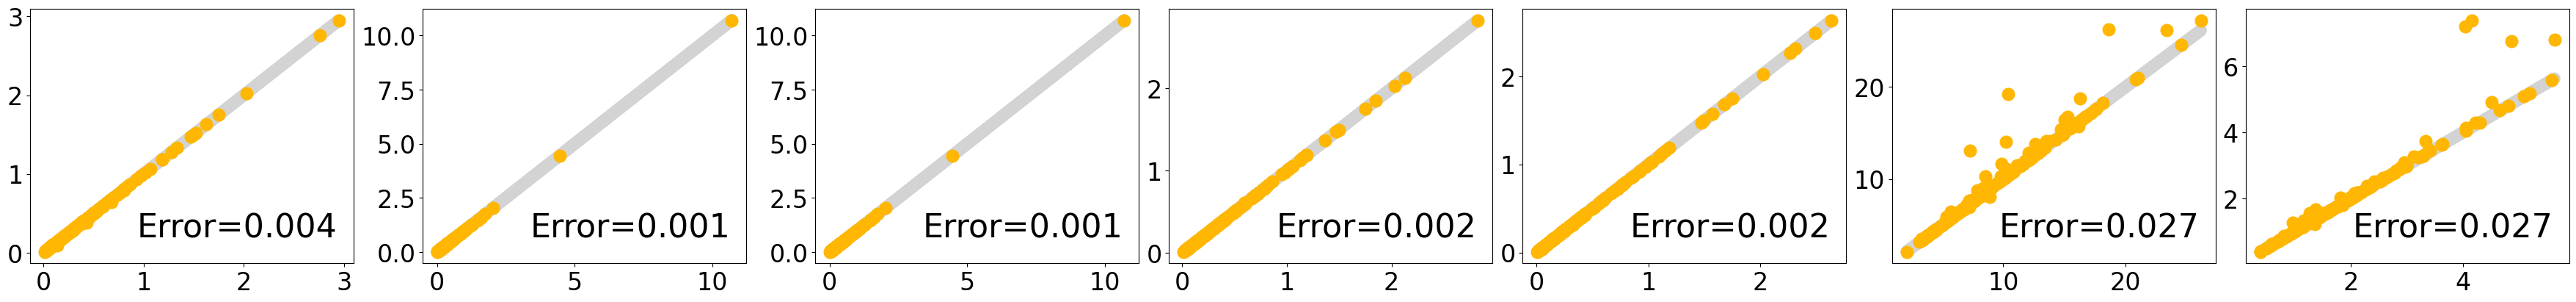

In [193]:
ax = plot_theta_ss(traj_true.theta, traj_temp.theta, dot_color='#ffb703')

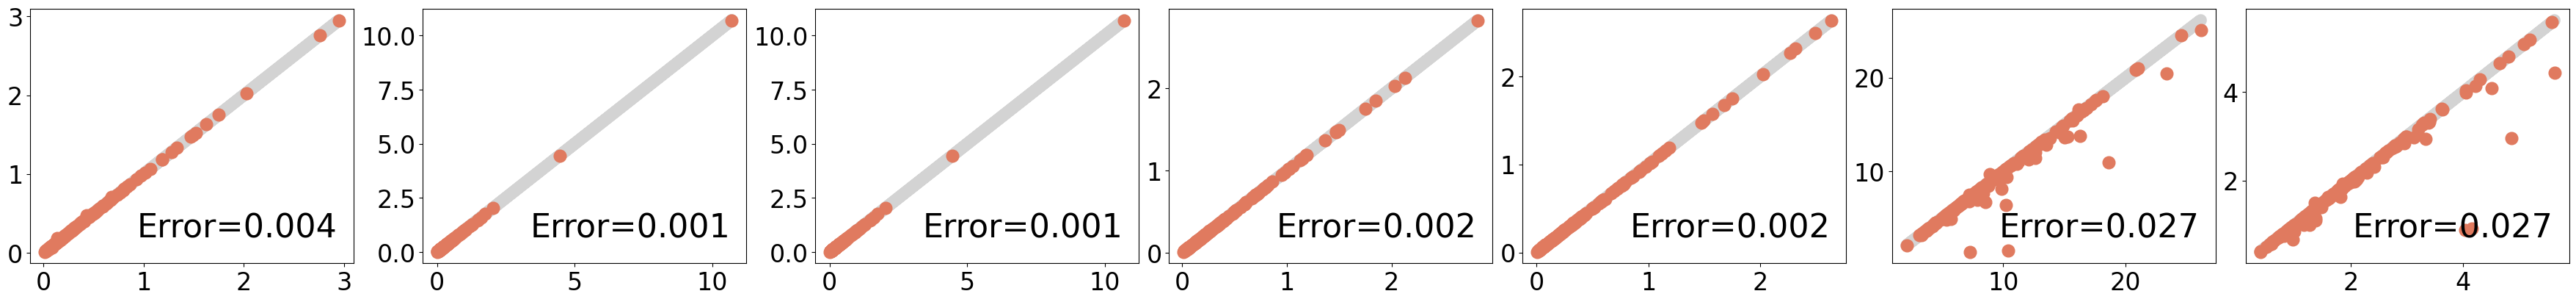

In [200]:
ax = plot_theta_ss(traj_true.theta, traj_temp2.theta, dot_color='#e07a5f')

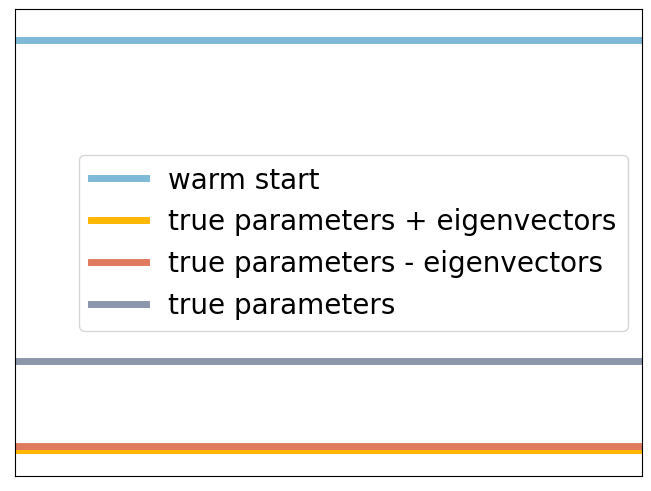

In [217]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.8))

ax.axhline(y=traj_ws.compute_lower_bound(traj.X),linewidth=5,markersize=15,label='warm start',color='#0074b3',alpha=0.5)
#ax.axhline(y=traj.compute_lower_bound(traj.X),linewidth=5,markersize=15,label='random init',color='#c74546',alpha=0.5)
ax.axhline(y=traj_temp.compute_lower_bound(traj.X),linewidth=5,markersize=15,label='true parameters + eigenvectors',color='#ffb703',alpha=1)
ax.axhline(y=traj_temp2.compute_lower_bound(traj.X),linewidth=5,markersize=15,label='true parameters - eigenvectors',color='#e07a5f',alpha=1)
ax.axhline(y=true_L,linewidth=5,color='#8b96ad',label='true parameters',zorder=0)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_ylim([-391.2,-391.1])
ax.legend(fontsize=20);

# Model selection

In [12]:
true_topo = np.array([[0,1,2],[0,1,3]])
true_t = (0,2,3)
topo=np.array([[0,1,2,3],[0,1,2,4]])
tau=(0,1.,2.,3.)
m=100
L=len(topo)

In [73]:
traj0 = Trajectory(true_topo, true_tau, model="two_species_ss", verbose=1)
traj0 = traj0.fit(X,m=traj.m,warm_start=True,theta=traj.theta[:,[0,1,3,4,-2,-1]],fit_tau=True,norm_Q=True,params={'r':r},epoch=100,parallel=True,n_threads=10,seed=seed)

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


100%|██████████| 100/100 [05:31<00:00,  3.32s/it]


In [74]:
traj0.elbos[-1],traj.elbos[-1][-1]

(-391.1179020100599, -391.1057102747658)

In [198]:
seed = 2
n = 5000
true_theta, true_t, Y, X, rd = simulate_demo_data(true_topo, true_tau, n=n, random_seed=seed, filepath=None, plot=False);
r = rd/rd.mean()

Input_args = []

def fit_wrapper(seed):
    traj0 = Trajectory(true_topo, true_tau, model="two_species_ss", verbose=0)
    traj0 = traj0.fit(X,m=100,n_init=1,fit_tau=True,norm_Q=True,params={'r':r},perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj0
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    traj0s = pool.starmap(fit_wrapper, Input_args, chunksize=1)

-412.6506122232925


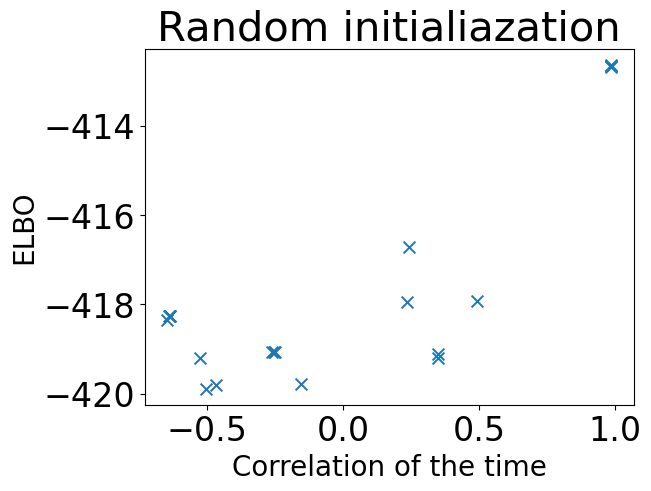

In [203]:
corrs = []
elbos = []
right_t = true_t
for traj in traj0s:
    t_hat = traj.Q.sum(1) @ traj.t
    corrs.append(stats.pearsonr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,s=1,marker='x')
#plt.axhline(y=Elbos['warm start'],color='gray')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

traj = traj0s[np.argmax(elbos)]
print(np.max(elbos))

In [200]:
traj.compute_AIC(X)

-412.786991357285

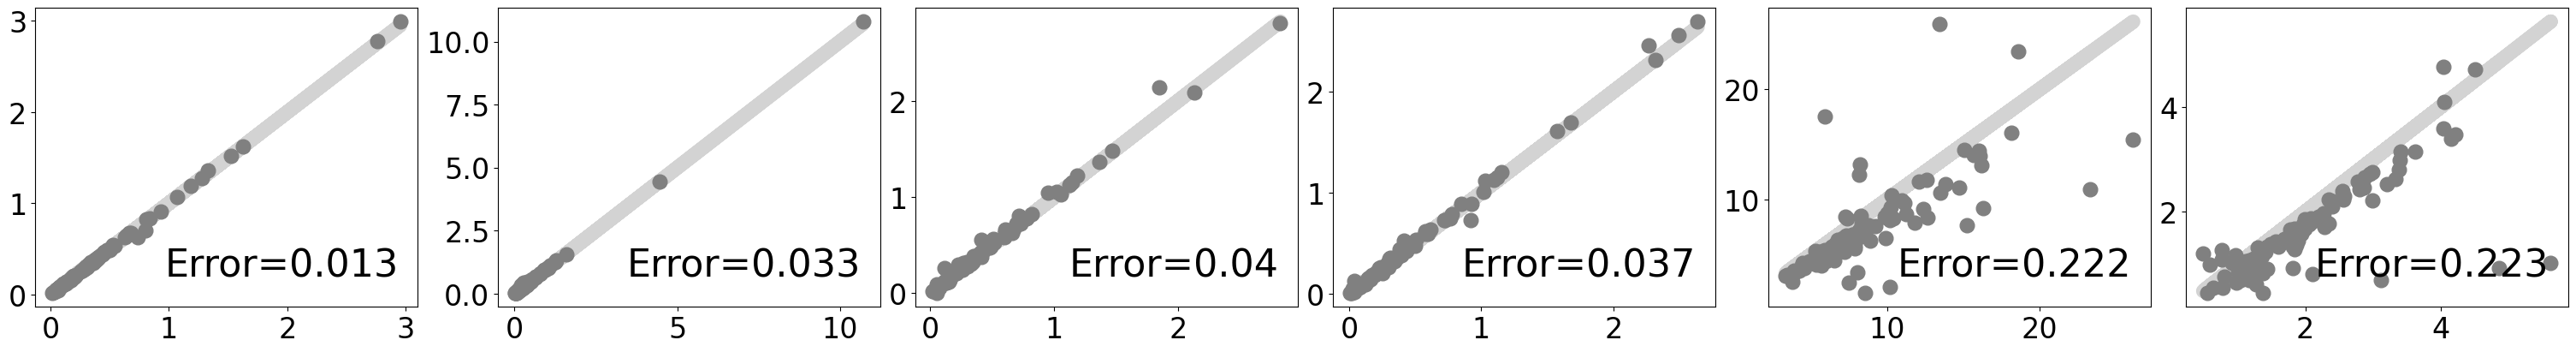

In [457]:
plot_theta_ss(true_theta[:100,[0,1,3,2,-2,-1]],traj.theta[:100]);

In [ ]:
n=5000

Input_args = []

def fit_wrapper(seed):
    true_theta, true_t, Y, X, rd = simulate_demo_data(true_topo, true_tau, n=n, random_seed=seed, filepath=None, plot=False);
    r = rd/rd.mean()

    traj1 = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj1 = traj1.fit(X,warm_start=False,params={'r':r},n_init=20,epoch=100,parallel=False)
    
    traj0 = Trajectory(true_topo, true_tau, model="two_species_ss", verbose=0)
    traj0 = traj0.fit(X,warm_start=False,params={'r':r},n_init=20,epoch=100,parallel=False)
    
    traj0.true_theta = true_theta.copy()   
    traj0.true_t = true_t.copy()
    traj0.Y = Y.copy()
    
    return (traj0,traj1)
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs_ms = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [228]:
with open('results/simulation_demo_new_ms.pickle', 'wb') as f:
    pickle.dump(trajs_ms, f, pickle.HIGHEST_PROTOCOL)

In [152]:
with open('results/simulation_demo_ms.pickle', 'rb') as f:
    trajs_ms = pickle.load(f)

In [248]:
seed = 19

true_theta, true_t, Y, X, rd = simulate_demo_data(true_topo, true_tau, n=n, random_seed=seed, filepath=None, plot=False);
r = rd/rd.mean()

traj0, traj1 = trajs_ms[seed]
traj0.compute_AIC(traj1.X), traj1.compute_AIC(traj1.X)

(-408.1933710795755, -407.8549953549901)

<AxesSubplot:>

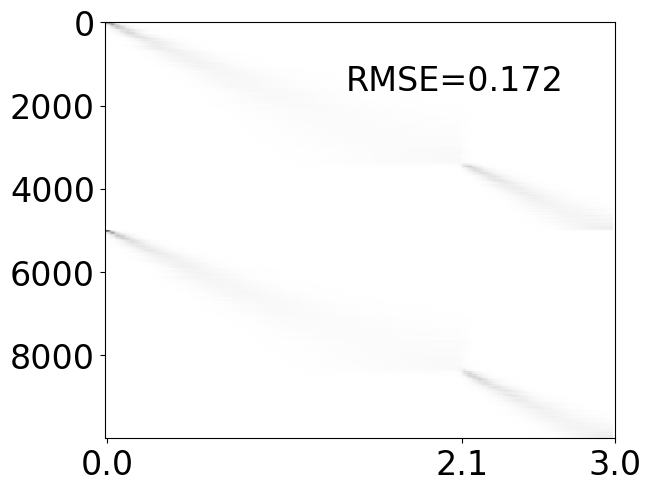

In [249]:
plot_t(traj0,t=traj0.true_t)

In [250]:
traj0.tau, traj1.tau

(array([0.        , 2.09406141, 3.        ]),
 array([0.        , 0.34094795, 2.06222678, 3.        ]))

In [251]:
traj0.compute_BIC(X),traj1.compute_BIC(X)

(-408.6096123679016, -408.33690955200177)

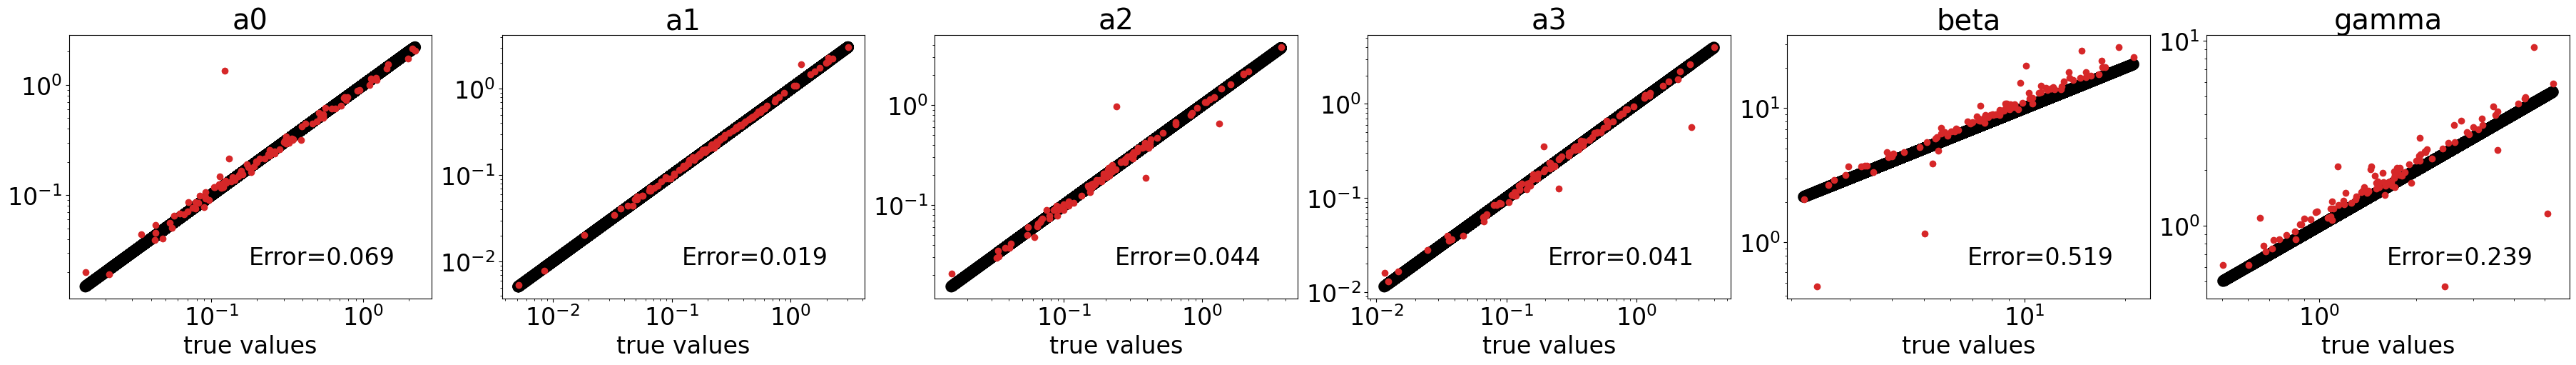

In [254]:
plot_theta(traj0.true_theta[:100,[0,1,3,2,-2,-1]],traj0.theta[:100]);

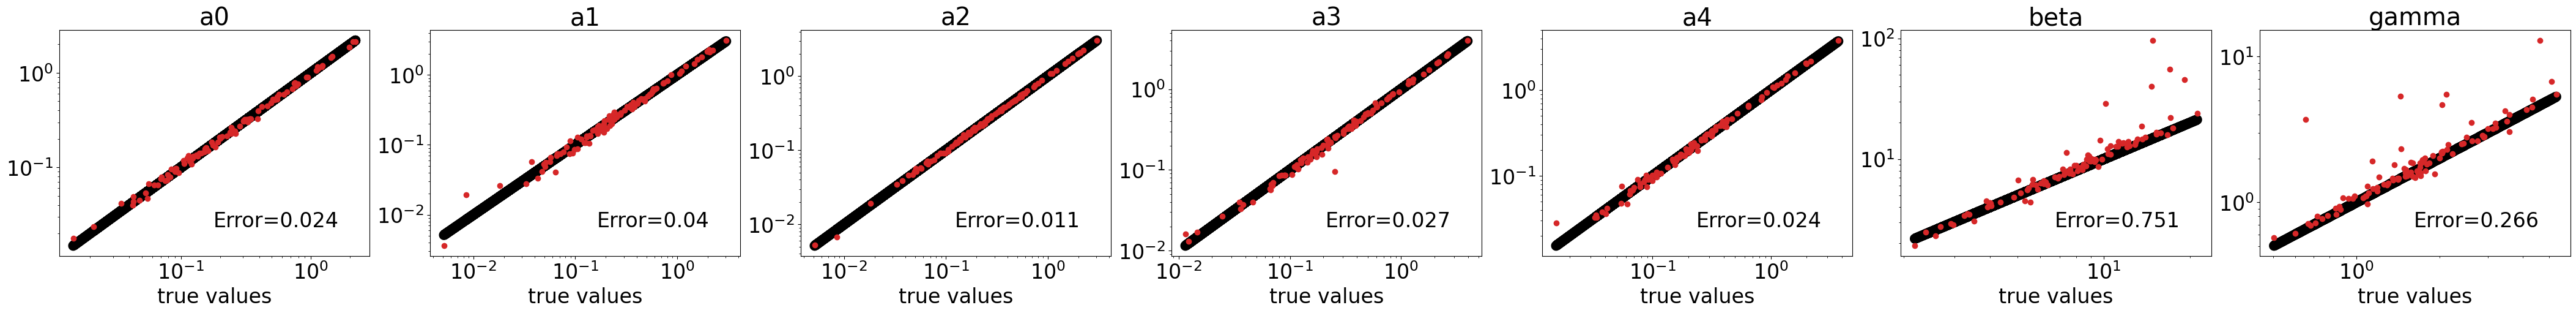

In [253]:
plot_theta(traj0.true_theta[:100,[0,1,1,2,3,-2,-1]],traj1.theta[:100]);

In [227]:
x=[]
y=[]
z=[]
w=[]
times=[]
KK=10
n=5000
L_idx = np.zeros(2*n,dtype=int)
L_idx[n:] = 1
for trajs in tqdm(trajs_ms):
    AIC = []
    BIC = []
    ELBO = []
    ELBO_out = np.zeros((2,KK))
    traj = trajs[0]
    Y = traj.get_Y_hat(theta=traj.true_theta, t=traj.true_t, tau=traj.tau, topo=traj.topo, params=traj.params)
    times.append(np.mean(np.abs(traj.true_t-traj.Q.sum(1)@traj.t)))
    for traj in trajs:
        AIC.append(traj.compute_AIC(traj.X))
        BIC.append(traj.compute_BIC(traj.X))
        ELBO.append(traj.compute_lower_bound(traj.X))
        
    for k in range(KK):
        X_test = np.random.poisson(traj.params['r'][:,None,None]*Y[L_idx,np.arange(2*n)])
        for j,traj in enumerate(trajs):
            ELBO_out[j,k] = traj.compute_lower_bound(X_test)
    x.append(np.argmax(AIC))
    y.append(np.argmax(BIC))
    z.append(np.argmax(ELBO))
    w.append(np.argmax(ELBO_out.mean(1)))

100%|██████████| 20/20 [02:20<00:00,  7.01s/it]


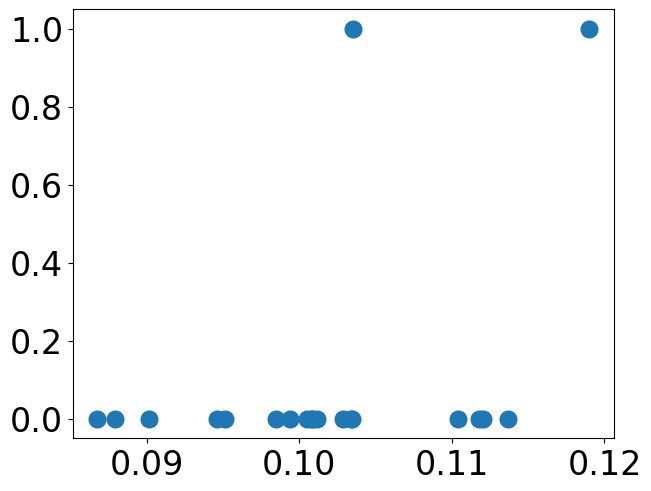

In [246]:
plt.scatter(times,w)

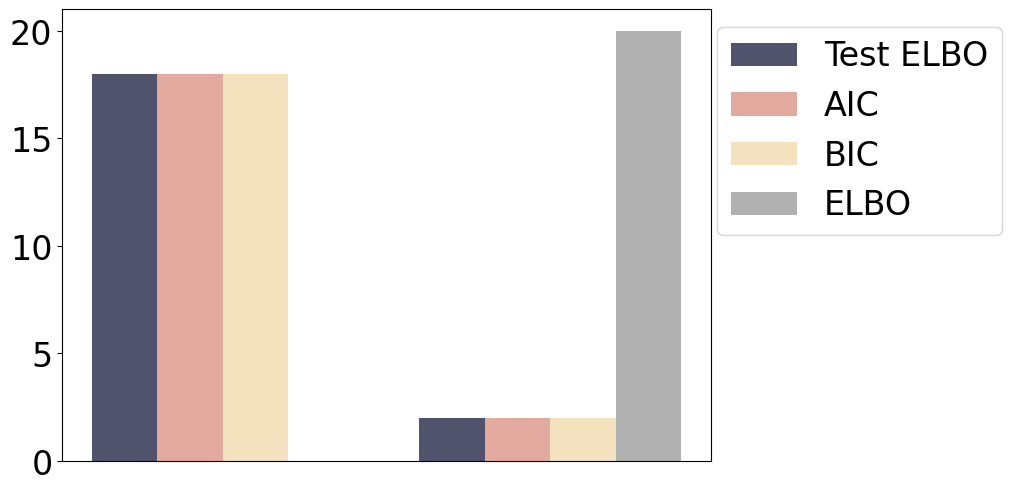

In [244]:
fig,ax = plt.subplots(1,1,figsize=(10,4.8))
ax.hist([w,x,y,z],label=["Test ELBO","AIC","BIC","ELBO"],bins=np.arange(3)-0.5,alpha=0.9,color=["#3d405b",'#e0a295',"#f3dfb7",'darkgray'])
ax.set_xticks([])
ax.legend(loc=(1.01,0.5),fontsize=legend_font)

# Model selection on noisy data

In [ ]:
n=5000
true_topo = np.array([[0,1,2],[0,1,3]])
true_t = (0,2,3)
topo=np.array([[0,1,2,3],[0,1,2,4]])
tau=(0,1.,2.,3.)
m=100
L=len(topo)
Input_args = []

def fit_wrapper(seed):
    true_theta, true_t, Y, X, rd = simulate_demo_data(true_topo, true_tau, n=n, phi=0.25, random_seed=seed, filepath=None, plot=False);
    r = rd/rd.mean()

    traj1 = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj1 = traj1.fit(X,warm_start=False,params={'r':r},n_init=20,epoch=100,parallel=False)
    
    traj0 = Trajectory(true_topo, true_tau, model="two_species_ss", verbose=0)
    traj0 = traj0.fit(X,warm_start=False,params={'r':r},n_init=20,epoch=100,parallel=False)
    
    traj0.true_theta = true_theta.copy()   
    traj0.true_t = true_t.copy()
    traj0.Y = Y.copy()
    
    return (traj0,traj1)
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(10) as pool:      
    trajs_ms = pool.starmap(fit_wrapper, Input_args, chunksize=1)

with open('results/simulation_demo_noisy_ms.pickle', 'wb') as f:
    pickle.dump(trajs_ms, f, pickle.HIGHEST_PROTOCOL)

In [11]:
with open('results/simulation_demo_noisy_ms.pickle', 'rb') as f:
    trajs_ms = pickle.load(f)

In [12]:
x=[]
y=[]
z=[]
w=[]
times=[]
KK=10
n=5000
L_idx = np.zeros(2*n,dtype=int)
L_idx[n:] = 1
for trajs in tqdm(trajs_ms):
    AIC = []
    BIC = []
    ELBO = []
    ELBO_out = np.zeros((2,KK))
    traj = trajs[0]
    Y = traj.get_Y_hat(theta=traj.true_theta, t=traj.true_t, tau=traj.tau, topo=traj.topo, params=traj.params)
    times.append(np.mean(np.abs(traj.true_t-traj.Q.sum(1)@traj.t)))
    for traj in trajs:
        AIC.append(traj.compute_AIC(traj.X))
        BIC.append(traj.compute_BIC(traj.X))
        ELBO.append(traj.compute_lower_bound(traj.X))
        
    for k in range(KK):
        X_test = np.random.poisson(traj.params['r'][:,None,None]*Y[L_idx,np.arange(2*n)])
        for j,traj in enumerate(trajs):
            ELBO_out[j,k] = traj.compute_lower_bound(X_test)
    x.append(np.argmax(AIC))
    y.append(np.argmax(BIC))
    z.append(np.argmax(ELBO))
    w.append(np.argmax(ELBO_out.mean(1)))

100%|██████████| 20/20 [02:03<00:00,  6.18s/it]


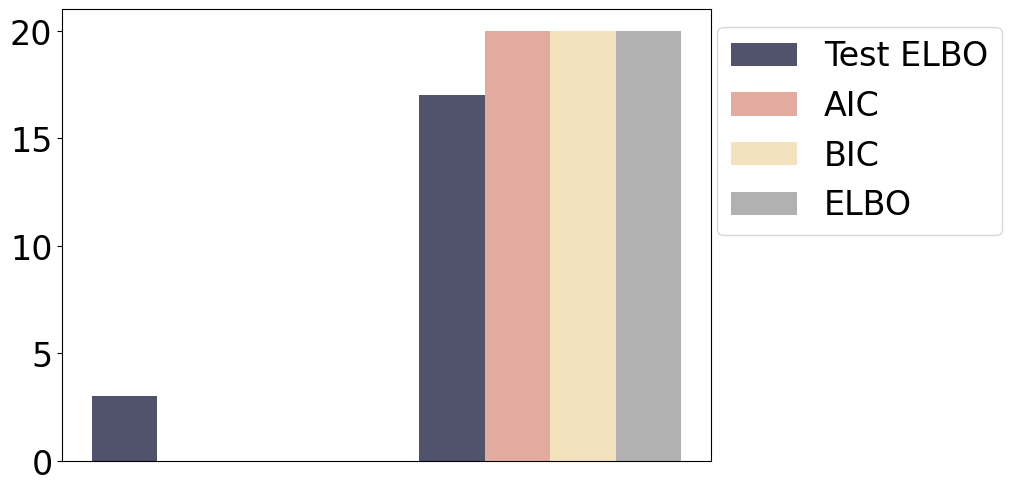

In [13]:
fig,ax = plt.subplots(1,1,figsize=(10,4.8))
ax.hist([w,x,y,z],label=["Test ELBO","AIC","BIC","ELBO"],bins=np.arange(3)-0.5,alpha=0.9,color=["#3d405b",'#e0a295',"#f3dfb7",'darkgray'])
ax.set_xticks([])
ax.legend(loc=(1.01,0.5),fontsize=legend_font)

# Slingshot

In [ ]:
import rpy2
import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [ ]:
#adata = ad.read('data/sim_demo.h5ad')
counts = adata.X.T

In [ ]:
%%R -i counts

library(tradeSeq, quietly = TRUE)
library(RColorBrewer, quietly = TRUE)
library(SingleCellExperiment, quietly = TRUE)
library(slingshot, quietly = TRUE)
library(umap, quietly = TRUE)
library(scran, quietly = TRUE)
library(scater, quietly = TRUE)
library(scuttle, quietly = TRUE)
library(Seurat, quietly = TRUE)
library(mclust, quietly = TRUE)

set.seed(42)
sce <- SingleCellExperiment(assays = list(counts = counts))
sce <- logNormCounts(sce)
dec_sce <- modelGeneVar(sce)
hvgs <- getTopHVGs(dec_sce)
sce <- runPCA(sce, subset_row = hvgs)
sce <- runUMAP(sce, subset_row = hvgs)
rd = reducedDims(sce)$PCA

In [ ]:
%%R
#cl <- Mclust(rd)$classification
#colData(sce)$GMM <- cl
cl <- kmeans(rd, centers = 4)$cluster
colData(sce)$kmeans <- cl

plot(rd, col = brewer.pal(9,"Set1")[cl], pch=16, asp = 1)

In [ ]:
%%R
# slingshot
sce <- slingshot(sce, clusterLabels = 'kmeans', reducedDim = 'PCA')
#pdf('principle_curve.pdf')
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(sce$slingPseudotime_1, breaks=100)]

In [ ]:
%%R
par(mar = c(4, 6, 0, 0))
plot(rd, col = plotcol, pch=16, asp=1, axes=F,cex=2,cex.lab=3)
lines(SlingshotDataSet(sce), lwd=8, col='black')
#axis(side = 1)

In [ ]:
from sklearn.manifold import TSNE
from umap import UMAP
import velocyto as vcy

def run_velocyto(loomfile,quiver_scale="auto"):
    vlm = vcy.VelocytoLoom(loomfile)
    # Preliminary Filtering
    vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))
    vlm.set_clusters(vlm.ca["cell_type"])
    #vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
    #vlm.filter_genes(by_detection_levels=True)
    #vlm.score_cv_vs_mean(100, plot=False, max_expr_avg=35)
    #vlm.filter_genes(by_cv_vs_mean=True)
    vlm._normalize_S(relative_size=vlm.S.sum(0),
                 target_size=vlm.S.sum(0).mean())
    vlm._normalize_U(relative_size=vlm.U.sum(0),
                 target_size=vlm.U.sum(0).mean())
    # Preparation for gamma fit
    vlm.perform_PCA()
    vlm.knn_imputation(n_pca_dims=20)
    # Gamma fit and extrapolation
    vlm.normalize_median()
    vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)
    vlm.normalize(which="imputed", size=False, log=True)
    vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")
    vlm.predict_U()
    vlm.calculate_velocity()
    vlm.calculate_shift(assumption="constant_velocity")
    vlm.extrapolate_cell_at_t(delta_t=1.)
    # Projection of velocity onto embeddings
    #vlm.ts = TSNE().fit_transform(vlm.pcs[:, :25])
    vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="sqrt", knn_random=True, sampled_fraction=0.5)
    vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)
    vlm.calculate_grid_arrows(smooth=0.5, steps=(25, 25))

    #vlm.colorandum = vlm.ca["time"]
    vlm.plot_grid_arrows(quiver_scale=quiver_scale,plot_random=True)
    
    #fig = plt.figure()
    #plt.plot(vlm.ra["true_gamma"]/vlm.ra["true_beta"],vlm.gammas,'.');
    #plt.plot(vlm.ra["true_gamma"]/vlm.ra["true_beta"],vlm.ra["true_gamma"]/vlm.ra["true_beta"],'r-');
    #plt.xscale('log')
    #plt.yscale('log')
    return vlm

In [ ]:
vlm = run_velocyto("data/sim_demo.h5ad",quiver_scale=0.1)